In [534]:
import praw
import pandas as pd
import string
import re
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

## Scrape Subreddits (with praw)

In [535]:
# reddit = praw.Reddit(client_id ='zWndV5hUJ8XZYshw1V9axw',
#                      client_secret ='4ovj54M6J9s4yS6alG7c58jKOa3TQA',
#                      user_agent ='my user agent')


In [536]:
# subs = ['bipolar', 'schizophrenia']
# submissions_types = ['hot', 'controversial', 'new', 'rising', 'top']

In [537]:
# for x in subs:
#     posts = []
#     subreddit = reddit.subreddit(x)

#     print(f'Starting to scrape for {x} subreddit')
#     print()

#     for submission_type in submissions_types:
#         submission_generator = getattr(subreddit, submission_type)(limit=1000)
#         posts.extend([[submission.id, submission.title, submission.selftext, submission.score, submission.num_comments, submission.author, submission.created_utc, submission.gilded] for submission in submission_generator])
#         print(f'{submission_type.capitalize()} posts from {x} subreddit scraped')

#     print(f'Scraping for {x} subreddit completed successfully')

#     df = pd.DataFrame(posts, columns=['id', 'title', 'text', 'score', 'comments_count', 'author', 'created_utc', 'gilding'])
#     df.to_csv(f'{x}.csv', index = False)

#     print(f'Exporting to csv for {x} subreddit completed successfully')
#     print('----------------------------------------')

## Scrape Subreddits (with reddit.json)

In [538]:
# import time
# import random
# import requests

In [539]:
# url_list = ['https://www.reddit.com/r/bipolar.json', 'https://www.reddit.com/r/schizophrenia.json']

In [540]:
# sub_count = 0

# for url in url_list:
#     headers = {'User-agent': 'Pony Inc 1.0'}
#     posts = []
#     after = None
    
#     print(f'Starting to scrape for {subs[sub_count]} subreddit')

#     for a in range(4):
#         if after:
#             current_url = f"{url}?after={after}"
#         else:
#             current_url = url

#         res = requests.get(current_url, headers=headers)
        
#         if res.status_code != 200:
#             print('Status error', res.status_code)
#             break
        
#         current_dict = res.json()
#         current_posts = [p['data'] for p in current_dict['data']['children']]
#         posts.extend(current_posts)
#         after = current_dict['data']['after']
        
#         if a > 0:
#             prev_posts = pd.read_csv(f'ryan_code_{subs[sub_count]}.csv')
#             current_df = pd.DataFrame(posts)
#             combined_df = pd.concat([prev_posts, current_df])
#             combined_df.to_csv(f'ryan_code_{subs[sub_count]}.csv', index = False)
#         else:
#             pd.DataFrame(posts).to_csv(f'ryan_code_{subs[sub_count]}.csv', index = False)

#         # generate a random sleep duration to look more 'natural'
#         sleep_duration = random.randint(2,6)
#         print('Sleeping for', sleep_duration, 'seconds.')
#         time.sleep(sleep_duration)
    
#     print(f'Scraping and exporting to csv for {subs[sub_count]} subreddit completed successfully')
#     print('------------------------------')
#     sub_count +=1

## Data Cleaning

### schizophrenia

Define a function to clean data by dropping na rows and duplicates, and combining title and text columns

In [541]:
def data_cleaning(dataframe):
    # drop rows with na
    dataframe.dropna(inplace=True)
    # drop duplicates
    dataframe.drop_duplicates(subset='id', keep='last', inplace=True)
    # Combine fields
    dataframe['combined_field'] = dataframe['title'] + ' ' + dataframe['text']
    return pd.DataFrame(dataframe)


Load in the Schizophrenia csv

In [542]:
schizophrenia_data = pd.read_csv('schizophrenia(1) Scraped by Althea.csv')

In [543]:
print(schizophrenia_data.shape)
schizophrenia_data.head()

(4016, 8)


,id,title,text,score,comments_count,author,created_utc,gilding
0,53xfmu,Frequently Asked Questions (Read This Sticky),Welcome to [/r/schizophrenia](https://www.redd...,44,7,soundandvisions,1.474520e+09,0
1,142vtbk,"Discord / Group Chat invites, the first Megath...",Hello!\n\nThere have been a growing number of ...,14,15,Ninlilizi,1.686091e+09,0
2,14akxab,outsider,NaN,12,0,vernetit,1.686883e+09,0
3,14a40b3,"""Karne"" - my solitary confinement",NaN,87,10,urspielsavaj,1.686840e+09,0
4,14acnmh,I’ve been wanting to be back at the psych ward,I don’t know why. My experience there was terr...,25,14,in-the_void,1.686861e+09,0


Run the schizophrenia df through the data cleaning function, and add label '0'. (bipolar will be label '1')

In [544]:
schizophrenia_data_cleaned = data_cleaning(schizophrenia_data)
schizophrenia_data_cleaned['label'] = 0
schizophrenia_data_cleaned

,id,title,text,score,comments_count,author,created_utc,gilding,combined_field,label
0,53xfmu,Frequently Asked Questions (Read This Sticky),Welcome to [/r/schizophrenia](https://www.redd...,44,7,soundandvisions,1.474520e+09,0,Frequently Asked Questions (Read This Sticky) ...,0
976,13tlqzi,Some art I’ve done.,Some art I’ve done in the past few weeks.,68,24,girludreamedof,1.685231e+09,0,Some art I’ve done. Some art I’ve done in the ...,0
978,13tibcc,Hospital/psych ward art,Here’s two of my drawings from when I was in t...,98,4,thiccpotatochipp,1.685222e+09,0,Hospital/psych ward art Here’s two of my drawi...,0
980,13tmt0l,Fear that suicide is my destiny,As a kid I would get this sick feeling in my g...,36,16,Zealousideal_Fly6576,1.685234e+09,0,Fear that suicide is my destiny As a kid I wou...,0
989,13tkfru,If this disease is incurable and Kan will fore...,Don’t think he wants to continue to live. Wont...,20,15,Professional-Pay6804,1.685227e+09,0,If this disease is incurable and Kan will fore...,0
...,...,...,...,...,...,...,...,...,...,...
3964,9clec2,I think this should be a safe space again.,I used to love browsing this subreddit. Part a...,185,81,PointBlank25,1.535981e+09,0,I think this should be a safe space again. I u...,0
3969,v6fevb,I did it!,I struggled a lot with my weight over the year...,182,42,Main-Talk-7064,1.654554e+09,0,I did it! I struggled a lot with my weight ove...,0
3995,12oays0,the amount of this stuff I see is annoying.,does this make anyone else uncomfortable?,177,77,whoreterrorist,1.681656e+09,0,the amount of this stuff I see is annoying. do...,0
4003,jcsgwz,Schizophrenia_specia is a scam,I need the mods to see this! \n\nThere is a pe...,175,21,Bluellan,1.602929e+09,0,Schizophrenia_specia is a scam I need the mods...,0


### bipolar

Load in the bipolar csv

In [545]:
bipolar_data = pd.read_csv('bipolar(1) Scraped by Althea.csv')

Run the bipolar df through the data cleaning function, and add label '1'. (schizophrenia will be label '0')

In [546]:
bipolar_data_cleaned = data_cleaning(bipolar_data)
bipolar_data_cleaned['label'] = 1
bipolar_data_cleaned

,id,title,text,score,comments_count,author,created_utc,gilding,combined_field,label
70,149w021,I'm a dumbass and I'm scared,I'm just a major dumbass. I was manic for mayb...,8,4,LeroyBarela,1.686815e+09,0,I'm a dumbass and I'm scared I'm just a major ...,1
874,131w2z4,I’m thinking of unfollowing this sub,Is it just me or does it seem as if some peopl...,7,65,imperfectlystupid,1.682694e+09,0,I’m thinking of unfollowing this sub Is it jus...,1
877,11ov0nr,No more medication. I Refuse.,Coming off my meds. I can’t live like this.\n\...,0,52,Interesting-Face22,1.678569e+09,0,No more medication. I Refuse. Coming off my me...,1
878,10ntsqj,I have psychic abilities even when I’m on medi...,I am new to this subreddit so forgive me if th...,0,27,yewesirnaym,1.674951e+09,0,I have psychic abilities even when I’m on medi...,1
879,da1hsu,Rules regarding selfies (DONT) and personal in...,**We're going to try out a week of NO MEMES.**...,11,180,sweetpea122,1.569596e+09,0,Rules regarding selfies (DONT) and personal in...,1
...,...,...,...,...,...,...,...,...,...,...
3793,dbyed4,I did a thing!,"I threw out my ""just in case pills."" It was a ...",786,70,SassBHW,1.569958e+09,0,"I did a thing! I threw out my ""just in case pi...",1
3823,k4gor5,(hypo)mania and depression aren't just intense...,I started Lamictal a couple months ago and thi...,768,71,fighterpilot909,1.606810e+09,0,(hypo)mania and depression aren't just intense...,1
3826,ig43dn,i fucking got in to grad school guys,i was cycling really hard my entire undergradu...,771,54,somethingsophie,1.598325e+09,0,i fucking got in to grad school guys i was cyc...,1
3864,lb1ouw,My semester GPA is 4.00!,My hands are shaking and I am in complete disb...,762,73,BipolarMindAtNotEase,1.612288e+09,0,My semester GPA is 4.00! My hands are shaking ...,1


## Merge both datasets

In [547]:
# Merge the both datasets into one dataset
combined_df = pd.merge(schizophrenia_data_cleaned, bipolar_data_cleaned, how = 'outer')
combined_df

,id,title,text,score,comments_count,author,created_utc,gilding,combined_field,label
0,53xfmu,Frequently Asked Questions (Read This Sticky),Welcome to [/r/schizophrenia](https://www.redd...,44,7,soundandvisions,1.474520e+09,0,Frequently Asked Questions (Read This Sticky) ...,0
1,13tlqzi,Some art I’ve done.,Some art I’ve done in the past few weeks.,68,24,girludreamedof,1.685231e+09,0,Some art I’ve done. Some art I’ve done in the ...,0
2,13tibcc,Hospital/psych ward art,Here’s two of my drawings from when I was in t...,98,4,thiccpotatochipp,1.685222e+09,0,Hospital/psych ward art Here’s two of my drawi...,0
3,13tmt0l,Fear that suicide is my destiny,As a kid I would get this sick feeling in my g...,36,16,Zealousideal_Fly6576,1.685234e+09,0,Fear that suicide is my destiny As a kid I wou...,0
4,13tkfru,If this disease is incurable and Kan will fore...,Don’t think he wants to continue to live. Wont...,20,15,Professional-Pay6804,1.685227e+09,0,If this disease is incurable and Kan will fore...,0
...,...,...,...,...,...,...,...,...,...,...
3237,dbyed4,I did a thing!,"I threw out my ""just in case pills."" It was a ...",786,70,SassBHW,1.569958e+09,0,"I did a thing! I threw out my ""just in case pi...",1
3238,k4gor5,(hypo)mania and depression aren't just intense...,I started Lamictal a couple months ago and thi...,768,71,fighterpilot909,1.606810e+09,0,(hypo)mania and depression aren't just intense...,1
3239,ig43dn,i fucking got in to grad school guys,i was cycling really hard my entire undergradu...,771,54,somethingsophie,1.598325e+09,0,i fucking got in to grad school guys i was cyc...,1
3240,lb1ouw,My semester GPA is 4.00!,My hands are shaking and I am in complete disb...,762,73,BipolarMindAtNotEase,1.612288e+09,0,My semester GPA is 4.00! My hands are shaking ...,1


Now that we have the merged datasets, the next steps will be to do a preliminary analysis of the individual words for each subreddit:
1. Remove punctuations
2. Tokenization to get individual words as tokens
3. Removing stopwords which are not relevant in the analysis and modelling
4. Lemmatization of the tokens
5. Count vectorization to get a dataframe of count of tokens

## Remove Punctuations

In [548]:
# Define function to remove punctuation
def remove_punct(text):
    # store character only if it is not a punctuation
    text_nopunct = "".join([char for char in text if char not in string.punctuation])
    return text_nopunct

In [549]:
combined_df['combined_field_nopunct'] = combined_df['combined_field'].apply(lambda x: remove_punct(x))
combined_df

,id,title,text,score,comments_count,author,created_utc,gilding,combined_field,label,combined_field_nopunct
0,53xfmu,Frequently Asked Questions (Read This Sticky),Welcome to [/r/schizophrenia](https://www.redd...,44,7,soundandvisions,1.474520e+09,0,Frequently Asked Questions (Read This Sticky) ...,0,Frequently Asked Questions Read This Sticky We...
1,13tlqzi,Some art I’ve done.,Some art I’ve done in the past few weeks.,68,24,girludreamedof,1.685231e+09,0,Some art I’ve done. Some art I’ve done in the ...,0,Some art I’ve done Some art I’ve done in the p...
2,13tibcc,Hospital/psych ward art,Here’s two of my drawings from when I was in t...,98,4,thiccpotatochipp,1.685222e+09,0,Hospital/psych ward art Here’s two of my drawi...,0,Hospitalpsych ward art Here’s two of my drawin...
3,13tmt0l,Fear that suicide is my destiny,As a kid I would get this sick feeling in my g...,36,16,Zealousideal_Fly6576,1.685234e+09,0,Fear that suicide is my destiny As a kid I wou...,0,Fear that suicide is my destiny As a kid I wou...
4,13tkfru,If this disease is incurable and Kan will fore...,Don’t think he wants to continue to live. Wont...,20,15,Professional-Pay6804,1.685227e+09,0,If this disease is incurable and Kan will fore...,0,If this disease is incurable and Kan will fore...
...,...,...,...,...,...,...,...,...,...,...,...
3237,dbyed4,I did a thing!,"I threw out my ""just in case pills."" It was a ...",786,70,SassBHW,1.569958e+09,0,"I did a thing! I threw out my ""just in case pi...",1,I did a thing I threw out my just in case pill...
3238,k4gor5,(hypo)mania and depression aren't just intense...,I started Lamictal a couple months ago and thi...,768,71,fighterpilot909,1.606810e+09,0,(hypo)mania and depression aren't just intense...,1,hypomania and depression arent just intense ve...
3239,ig43dn,i fucking got in to grad school guys,i was cycling really hard my entire undergradu...,771,54,somethingsophie,1.598325e+09,0,i fucking got in to grad school guys i was cyc...,1,i fucking got in to grad school guys i was cyc...
3240,lb1ouw,My semester GPA is 4.00!,My hands are shaking and I am in complete disb...,762,73,BipolarMindAtNotEase,1.612288e+09,0,My semester GPA is 4.00! My hands are shaking ...,1,My semester GPA is 400 My hands are shaking an...


## Tokenization

In [550]:
# define function for tokenization
def tokenize(text):
    tokens = re.split('\W+', text)
    return tokens

In [551]:
combined_df['combined_field_nopunct_tokens'] = combined_df['combined_field_nopunct'].apply(lambda x: tokenize(x.lower()))
combined_df

,id,title,text,score,comments_count,author,created_utc,gilding,combined_field,label,combined_field_nopunct,combined_field_nopunct_tokens
0,53xfmu,Frequently Asked Questions (Read This Sticky),Welcome to [/r/schizophrenia](https://www.redd...,44,7,soundandvisions,1.474520e+09,0,Frequently Asked Questions (Read This Sticky) ...,0,Frequently Asked Questions Read This Sticky We...,"[frequently, asked, questions, read, this, sti..."
1,13tlqzi,Some art I’ve done.,Some art I’ve done in the past few weeks.,68,24,girludreamedof,1.685231e+09,0,Some art I’ve done. Some art I’ve done in the ...,0,Some art I’ve done Some art I’ve done in the p...,"[some, art, i, ve, done, some, art, i, ve, don..."
2,13tibcc,Hospital/psych ward art,Here’s two of my drawings from when I was in t...,98,4,thiccpotatochipp,1.685222e+09,0,Hospital/psych ward art Here’s two of my drawi...,0,Hospitalpsych ward art Here’s two of my drawin...,"[hospitalpsych, ward, art, here, s, two, of, m..."
3,13tmt0l,Fear that suicide is my destiny,As a kid I would get this sick feeling in my g...,36,16,Zealousideal_Fly6576,1.685234e+09,0,Fear that suicide is my destiny As a kid I wou...,0,Fear that suicide is my destiny As a kid I wou...,"[fear, that, suicide, is, my, destiny, as, a, ..."
4,13tkfru,If this disease is incurable and Kan will fore...,Don’t think he wants to continue to live. Wont...,20,15,Professional-Pay6804,1.685227e+09,0,If this disease is incurable and Kan will fore...,0,If this disease is incurable and Kan will fore...,"[if, this, disease, is, incurable, and, kan, w..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3237,dbyed4,I did a thing!,"I threw out my ""just in case pills."" It was a ...",786,70,SassBHW,1.569958e+09,0,"I did a thing! I threw out my ""just in case pi...",1,I did a thing I threw out my just in case pill...,"[i, did, a, thing, i, threw, out, my, just, in..."
3238,k4gor5,(hypo)mania and depression aren't just intense...,I started Lamictal a couple months ago and thi...,768,71,fighterpilot909,1.606810e+09,0,(hypo)mania and depression aren't just intense...,1,hypomania and depression arent just intense ve...,"[hypomania, and, depression, arent, just, inte..."
3239,ig43dn,i fucking got in to grad school guys,i was cycling really hard my entire undergradu...,771,54,somethingsophie,1.598325e+09,0,i fucking got in to grad school guys i was cyc...,1,i fucking got in to grad school guys i was cyc...,"[i, fucking, got, in, to, grad, school, guys, ..."
3240,lb1ouw,My semester GPA is 4.00!,My hands are shaking and I am in complete disb...,762,73,BipolarMindAtNotEase,1.612288e+09,0,My semester GPA is 4.00! My hands are shaking ...,1,My semester GPA is 400 My hands are shaking an...,"[my, semester, gpa, is, 400, my, hands, are, s..."


## Remove Stopwords

In [552]:
stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()
wn = nltk.WordNetLemmatizer()

In [553]:
# Define function to remove stop words
def remove_stopwords(tokenized_list):
    # Store in text only if word is not found in stopwords
    text = [word for word in tokenized_list if word not in stopwords]
    return text

# Remove stopwords from the 'title and selftext' column
combined_df['combined_field_nopunct_tokens_nostop'] = combined_df['combined_field_nopunct_tokens'].apply(
    lambda x: remove_stopwords(x))

combined_df

,id,title,text,score,comments_count,author,created_utc,gilding,combined_field,label,combined_field_nopunct,combined_field_nopunct_tokens,combined_field_nopunct_tokens_nostop
0,53xfmu,Frequently Asked Questions (Read This Sticky),Welcome to [/r/schizophrenia](https://www.redd...,44,7,soundandvisions,1.474520e+09,0,Frequently Asked Questions (Read This Sticky) ...,0,Frequently Asked Questions Read This Sticky We...,"[frequently, asked, questions, read, this, sti...","[frequently, asked, questions, read, sticky, w..."
1,13tlqzi,Some art I’ve done.,Some art I’ve done in the past few weeks.,68,24,girludreamedof,1.685231e+09,0,Some art I’ve done. Some art I’ve done in the ...,0,Some art I’ve done Some art I’ve done in the p...,"[some, art, i, ve, done, some, art, i, ve, don...","[art, done, art, done, past, weeks]"
2,13tibcc,Hospital/psych ward art,Here’s two of my drawings from when I was in t...,98,4,thiccpotatochipp,1.685222e+09,0,Hospital/psych ward art Here’s two of my drawi...,0,Hospitalpsych ward art Here’s two of my drawin...,"[hospitalpsych, ward, art, here, s, two, of, m...","[hospitalpsych, ward, art, two, drawings, hosp..."
3,13tmt0l,Fear that suicide is my destiny,As a kid I would get this sick feeling in my g...,36,16,Zealousideal_Fly6576,1.685234e+09,0,Fear that suicide is my destiny As a kid I wou...,0,Fear that suicide is my destiny As a kid I wou...,"[fear, that, suicide, is, my, destiny, as, a, ...","[fear, suicide, destiny, kid, would, get, sick..."
4,13tkfru,If this disease is incurable and Kan will fore...,Don’t think he wants to continue to live. Wont...,20,15,Professional-Pay6804,1.685227e+09,0,If this disease is incurable and Kan will fore...,0,If this disease is incurable and Kan will fore...,"[if, this, disease, is, incurable, and, kan, w...","[disease, incurable, kan, forever, like, think..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3237,dbyed4,I did a thing!,"I threw out my ""just in case pills."" It was a ...",786,70,SassBHW,1.569958e+09,0,"I did a thing! I threw out my ""just in case pi...",1,I did a thing I threw out my just in case pill...,"[i, did, a, thing, i, threw, out, my, just, in...","[thing, threw, case, pills, huge, bottle, left..."
3238,k4gor5,(hypo)mania and depression aren't just intense...,I started Lamictal a couple months ago and thi...,768,71,fighterpilot909,1.606810e+09,0,(hypo)mania and depression aren't just intense...,1,hypomania and depression arent just intense ve...,"[hypomania, and, depression, arent, just, inte...","[hypomania, depression, arent, intense, versio..."
3239,ig43dn,i fucking got in to grad school guys,i was cycling really hard my entire undergradu...,771,54,somethingsophie,1.598325e+09,0,i fucking got in to grad school guys i was cyc...,1,i fucking got in to grad school guys i was cyc...,"[i, fucking, got, in, to, grad, school, guys, ...","[fucking, got, grad, school, guys, cycling, re..."
3240,lb1ouw,My semester GPA is 4.00!,My hands are shaking and I am in complete disb...,762,73,BipolarMindAtNotEase,1.612288e+09,0,My semester GPA is 4.00! My hands are shaking ...,1,My semester GPA is 400 My hands are shaking an...,"[my, semester, gpa, is, 400, my, hands, are, s...","[semester, gpa, 400, hands, shaking, complete,..."


## Lemmatization

In [554]:
wn = nltk.WordNetLemmatizer() 

In [555]:
# Define function for lemmatization
def lemmatizing(tokenized_text):
    # return list of all lemmatized words for their corresponding words in tokenized_text
    text = [wn.lemmatize(word) for word in tokenized_text]
    return text

# Remove stopwords from the 'title and selftext' column
combined_df['combined_field_nopunct_tokens_nostop_lem'] = combined_df['combined_field_nopunct_tokens_nostop'].apply(
    lambda x: lemmatizing(x))

combined_df


,id,title,text,score,comments_count,author,created_utc,gilding,combined_field,label,combined_field_nopunct,combined_field_nopunct_tokens,combined_field_nopunct_tokens_nostop,combined_field_nopunct_tokens_nostop_lem
0,53xfmu,Frequently Asked Questions (Read This Sticky),Welcome to [/r/schizophrenia](https://www.redd...,44,7,soundandvisions,1.474520e+09,0,Frequently Asked Questions (Read This Sticky) ...,0,Frequently Asked Questions Read This Sticky We...,"[frequently, asked, questions, read, this, sti...","[frequently, asked, questions, read, sticky, w...","[frequently, asked, question, read, sticky, we..."
1,13tlqzi,Some art I’ve done.,Some art I’ve done in the past few weeks.,68,24,girludreamedof,1.685231e+09,0,Some art I’ve done. Some art I’ve done in the ...,0,Some art I’ve done Some art I’ve done in the p...,"[some, art, i, ve, done, some, art, i, ve, don...","[art, done, art, done, past, weeks]","[art, done, art, done, past, week]"
2,13tibcc,Hospital/psych ward art,Here’s two of my drawings from when I was in t...,98,4,thiccpotatochipp,1.685222e+09,0,Hospital/psych ward art Here’s two of my drawi...,0,Hospitalpsych ward art Here’s two of my drawin...,"[hospitalpsych, ward, art, here, s, two, of, m...","[hospitalpsych, ward, art, two, drawings, hosp...","[hospitalpsych, ward, art, two, drawing, hospi..."
3,13tmt0l,Fear that suicide is my destiny,As a kid I would get this sick feeling in my g...,36,16,Zealousideal_Fly6576,1.685234e+09,0,Fear that suicide is my destiny As a kid I wou...,0,Fear that suicide is my destiny As a kid I wou...,"[fear, that, suicide, is, my, destiny, as, a, ...","[fear, suicide, destiny, kid, would, get, sick...","[fear, suicide, destiny, kid, would, get, sick..."
4,13tkfru,If this disease is incurable and Kan will fore...,Don’t think he wants to continue to live. Wont...,20,15,Professional-Pay6804,1.685227e+09,0,If this disease is incurable and Kan will fore...,0,If this disease is incurable and Kan will fore...,"[if, this, disease, is, incurable, and, kan, w...","[disease, incurable, kan, forever, like, think...","[disease, incurable, kan, forever, like, think..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3237,dbyed4,I did a thing!,"I threw out my ""just in case pills."" It was a ...",786,70,SassBHW,1.569958e+09,0,"I did a thing! I threw out my ""just in case pi...",1,I did a thing I threw out my just in case pill...,"[i, did, a, thing, i, threw, out, my, just, in...","[thing, threw, case, pills, huge, bottle, left...","[thing, threw, case, pill, huge, bottle, lefto..."
3238,k4gor5,(hypo)mania and depression aren't just intense...,I started Lamictal a couple months ago and thi...,768,71,fighterpilot909,1.606810e+09,0,(hypo)mania and depression aren't just intense...,1,hypomania and depression arent just intense ve...,"[hypomania, and, depression, arent, just, inte...","[hypomania, depression, arent, intense, versio...","[hypomania, depression, arent, intense, versio..."
3239,ig43dn,i fucking got in to grad school guys,i was cycling really hard my entire undergradu...,771,54,somethingsophie,1.598325e+09,0,i fucking got in to grad school guys i was cyc...,1,i fucking got in to grad school guys i was cyc...,"[i, fucking, got, in, to, grad, school, guys, ...","[fucking, got, grad, school, guys, cycling, re...","[fucking, got, grad, school, guy, cycling, rea..."
3240,lb1ouw,My semester GPA is 4.00!,My hands are shaking and I am in complete disb...,762,73,BipolarMindAtNotEase,1.612288e+09,0,My semester GPA is 4.00! My hands are shaking ...,1,My semester GPA is 400 My hands are shaking an...,"[my, semester, gpa, is, 400, my, hands, are, s...","[semester, gpa, 400, hands, shaking, complete,...","[semester, gpa, 400, hand, shaking, complete, ..."


## Count Vectorizer

Define a function for CountVectorizer

In [556]:
def make_count_vectorizer(df):
    # Create an instance of CountVectorizer and pass in the clean_text function as the analyzer parameter
    count_vect = CountVectorizer(analyzer = lemmatizing)

    X_counts = count_vect.fit_transform(df)
    
    X_counts_df = pd.DataFrame(X_counts.toarray())
    
    X_counts_df.columns = count_vect.get_feature_names_out()
    
    return X_counts_df

In [557]:
# checking if the function works, and preview the words in the dataframe
X_counts_preview = make_count_vectorizer(combined_df['combined_field_nopunct_tokens_nostop_lem'])
X_counts_preview

,,0,000001,01,025,03,031,05,050,05hz,...,zyprexa,zyprexas,zzz,ツ,글s,남자,서녀시대,아래,이믈을,퉁퉁해수퍼맨
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3237,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3238,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3239,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3240,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


There are several tokens with numbers and non-English words. They need to be removed

In [558]:
# Define function to remove words with numbers
def remove_num(text):
    text = (re.sub('\d+', '', word) for word in text)
    text = [word for word in text if word != '']
    return text

# Define function to remove non-english words
def remove_non_english(text):
    text = [word for word in text if word.isascii() == True]
    return text

# Remove words with numbers
combined_df['combined_field_nopunct_tokens_nostop_lem'] = combined_df['combined_field_nopunct_tokens_nostop_lem'].apply(
    lambda x: remove_num(x))


# Remove words with non-english words
combined_df['combined_field_nopunct_tokens_nostop_lem'] = combined_df['combined_field_nopunct_tokens_nostop_lem'].apply(
    lambda x: remove_non_english(x))

combined_df

,id,title,text,score,comments_count,author,created_utc,gilding,combined_field,label,combined_field_nopunct,combined_field_nopunct_tokens,combined_field_nopunct_tokens_nostop,combined_field_nopunct_tokens_nostop_lem
0,53xfmu,Frequently Asked Questions (Read This Sticky),Welcome to [/r/schizophrenia](https://www.redd...,44,7,soundandvisions,1.474520e+09,0,Frequently Asked Questions (Read This Sticky) ...,0,Frequently Asked Questions Read This Sticky We...,"[frequently, asked, questions, read, this, sti...","[frequently, asked, questions, read, sticky, w...","[frequently, asked, question, read, sticky, we..."
1,13tlqzi,Some art I’ve done.,Some art I’ve done in the past few weeks.,68,24,girludreamedof,1.685231e+09,0,Some art I’ve done. Some art I’ve done in the ...,0,Some art I’ve done Some art I’ve done in the p...,"[some, art, i, ve, done, some, art, i, ve, don...","[art, done, art, done, past, weeks]","[art, done, art, done, past, week]"
2,13tibcc,Hospital/psych ward art,Here’s two of my drawings from when I was in t...,98,4,thiccpotatochipp,1.685222e+09,0,Hospital/psych ward art Here’s two of my drawi...,0,Hospitalpsych ward art Here’s two of my drawin...,"[hospitalpsych, ward, art, here, s, two, of, m...","[hospitalpsych, ward, art, two, drawings, hosp...","[hospitalpsych, ward, art, two, drawing, hospi..."
3,13tmt0l,Fear that suicide is my destiny,As a kid I would get this sick feeling in my g...,36,16,Zealousideal_Fly6576,1.685234e+09,0,Fear that suicide is my destiny As a kid I wou...,0,Fear that suicide is my destiny As a kid I wou...,"[fear, that, suicide, is, my, destiny, as, a, ...","[fear, suicide, destiny, kid, would, get, sick...","[fear, suicide, destiny, kid, would, get, sick..."
4,13tkfru,If this disease is incurable and Kan will fore...,Don’t think he wants to continue to live. Wont...,20,15,Professional-Pay6804,1.685227e+09,0,If this disease is incurable and Kan will fore...,0,If this disease is incurable and Kan will fore...,"[if, this, disease, is, incurable, and, kan, w...","[disease, incurable, kan, forever, like, think...","[disease, incurable, kan, forever, like, think..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3237,dbyed4,I did a thing!,"I threw out my ""just in case pills."" It was a ...",786,70,SassBHW,1.569958e+09,0,"I did a thing! I threw out my ""just in case pi...",1,I did a thing I threw out my just in case pill...,"[i, did, a, thing, i, threw, out, my, just, in...","[thing, threw, case, pills, huge, bottle, left...","[thing, threw, case, pill, huge, bottle, lefto..."
3238,k4gor5,(hypo)mania and depression aren't just intense...,I started Lamictal a couple months ago and thi...,768,71,fighterpilot909,1.606810e+09,0,(hypo)mania and depression aren't just intense...,1,hypomania and depression arent just intense ve...,"[hypomania, and, depression, arent, just, inte...","[hypomania, depression, arent, intense, versio...","[hypomania, depression, arent, intense, versio..."
3239,ig43dn,i fucking got in to grad school guys,i was cycling really hard my entire undergradu...,771,54,somethingsophie,1.598325e+09,0,i fucking got in to grad school guys i was cyc...,1,i fucking got in to grad school guys i was cyc...,"[i, fucking, got, in, to, grad, school, guys, ...","[fucking, got, grad, school, guys, cycling, re...","[fucking, got, grad, school, guy, cycling, rea..."
3240,lb1ouw,My semester GPA is 4.00!,My hands are shaking and I am in complete disb...,762,73,BipolarMindAtNotEase,1.612288e+09,0,My semester GPA is 4.00! My hands are shaking ...,1,My semester GPA is 400 My hands are shaking an...,"[my, semester, gpa, is, 400, my, hands, are, s...","[semester, gpa, 400, hands, shaking, complete,...","[semester, gpa, hand, shaking, complete, disbe..."


In [559]:
# checking if numbers and non-english words have been removed
X_counts2_df = make_count_vectorizer(combined_df['combined_field_nopunct_tokens_nostop_lem'])
X_counts2_df

,a,aa,aaaaaaahhhh,aaam,aaand,aah,aaida,aaim,aaron,ab,...,zoom,zoomies,zooming,zopiclone,zopiclones,zoro,zurprisadone,zyprexa,zyprexas,zzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3237,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3238,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3239,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3240,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We are ready to begin the exploratory data analysis

## Exploratory Data Analysis

Separate the subreddits based on filtering the label for individual analysis, then CountVectorize each of them

In [560]:
# get df of schizophrenia only
schizophrenia_df_cleaned = combined_df[combined_df['label'] == 0]

# get df of bipolar only
bipolar_df_cleaned = combined_df[combined_df['label'] == 1]

# Check the words of each subreddit separately
schizophrenia_df_cleaned_countvec = make_count_vectorizer(schizophrenia_df_cleaned['combined_field_nopunct_tokens_nostop_lem'])

bipolar_df_cleaned_countvec = make_count_vectorizer(bipolar_df_cleaned['combined_field_nopunct_tokens_nostop_lem'])


In [561]:
# Checking that the subreddits have been separated
schizophrenia_df_cleaned

,id,title,text,score,comments_count,author,created_utc,gilding,combined_field,label,combined_field_nopunct,combined_field_nopunct_tokens,combined_field_nopunct_tokens_nostop,combined_field_nopunct_tokens_nostop_lem
0,53xfmu,Frequently Asked Questions (Read This Sticky),Welcome to [/r/schizophrenia](https://www.redd...,44,7,soundandvisions,1.474520e+09,0,Frequently Asked Questions (Read This Sticky) ...,0,Frequently Asked Questions Read This Sticky We...,"[frequently, asked, questions, read, this, sti...","[frequently, asked, questions, read, sticky, w...","[frequently, asked, question, read, sticky, we..."
1,13tlqzi,Some art I’ve done.,Some art I’ve done in the past few weeks.,68,24,girludreamedof,1.685231e+09,0,Some art I’ve done. Some art I’ve done in the ...,0,Some art I’ve done Some art I’ve done in the p...,"[some, art, i, ve, done, some, art, i, ve, don...","[art, done, art, done, past, weeks]","[art, done, art, done, past, week]"
2,13tibcc,Hospital/psych ward art,Here’s two of my drawings from when I was in t...,98,4,thiccpotatochipp,1.685222e+09,0,Hospital/psych ward art Here’s two of my drawi...,0,Hospitalpsych ward art Here’s two of my drawin...,"[hospitalpsych, ward, art, here, s, two, of, m...","[hospitalpsych, ward, art, two, drawings, hosp...","[hospitalpsych, ward, art, two, drawing, hospi..."
3,13tmt0l,Fear that suicide is my destiny,As a kid I would get this sick feeling in my g...,36,16,Zealousideal_Fly6576,1.685234e+09,0,Fear that suicide is my destiny As a kid I wou...,0,Fear that suicide is my destiny As a kid I wou...,"[fear, that, suicide, is, my, destiny, as, a, ...","[fear, suicide, destiny, kid, would, get, sick...","[fear, suicide, destiny, kid, would, get, sick..."
4,13tkfru,If this disease is incurable and Kan will fore...,Don’t think he wants to continue to live. Wont...,20,15,Professional-Pay6804,1.685227e+09,0,If this disease is incurable and Kan will fore...,0,If this disease is incurable and Kan will fore...,"[if, this, disease, is, incurable, and, kan, w...","[disease, incurable, kan, forever, like, think...","[disease, incurable, kan, forever, like, think..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1611,9clec2,I think this should be a safe space again.,I used to love browsing this subreddit. Part a...,185,81,PointBlank25,1.535981e+09,0,I think this should be a safe space again. I u...,0,I think this should be a safe space again I us...,"[i, think, this, should, be, a, safe, space, a...","[think, safe, space, used, love, browsing, sub...","[think, safe, space, used, love, browsing, sub..."
1612,v6fevb,I did it!,I struggled a lot with my weight over the year...,182,42,Main-Talk-7064,1.654554e+09,0,I did it! I struggled a lot with my weight ove...,0,I did it I struggled a lot with my weight over...,"[i, did, it, i, struggled, a, lot, with, my, w...","[struggled, lot, weight, years, especially, me...","[struggled, lot, weight, year, especially, med..."
1613,12oays0,the amount of this stuff I see is annoying.,does this make anyone else uncomfortable?,177,77,whoreterrorist,1.681656e+09,0,the amount of this stuff I see is annoying. do...,0,the amount of this stuff I see is annoying doe...,"[the, amount, of, this, stuff, i, see, is, ann...","[amount, stuff, see, annoying, make, anyone, e...","[amount, stuff, see, annoying, make, anyone, e..."
1614,jcsgwz,Schizophrenia_specia is a scam,I need the mods to see this! \n\nThere is a pe...,175,21,Bluellan,1.602929e+09,0,Schizophrenia_specia is a scam I need the mods...,0,Schizophreniaspecia is a scam I need the mods ...,"[schizophreniaspecia, is, a, scam, i, need, th...","[schizophreniaspecia, scam, need, mods, see, p...","[schizophreniaspecia, scam, need, mod, see, pe..."


### Zooming in on Schizophrenia

In [562]:
# checking that the schizophrenia dataset has been CountVectorized
schizophrenia_df_cleaned_countvec

,a,aa,aaam,aaand,aah,aaida,aaim,aaron,ab,abandon,...,zone,zoning,zoom,zoomies,zooming,zoro,zurprisadone,zyprexa,zyprexas,zzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1612,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1613,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1614,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [563]:
# preview the top 50 words in schizophrenia
schizophrenia_df_cleaned_countvec_top50 = schizophrenia_df_cleaned_countvec.sum().sort_values(ascending=False).head(50)
schizophrenia_df_cleaned_countvec_top50

like             1724
im               1386
schizophrenia    1210
people            930
know              919
feel              917
get               825
thing             765
time              747
dont              730
voice             694
think             663
want              609
one               585
really            575
would             565
help              563
thought           544
year              542
day               492
life              487
even              485
also              480
ive               476
go                464
make              434
something         418
way               409
see               402
symptom           389
going             389
say               379
anyone            378
could             369
take              360
experience        347
got               338
much              337
someone           332
still             330
schizophrenic     329
hallucination     315
back              314
mental            303
friend            296
delusion  

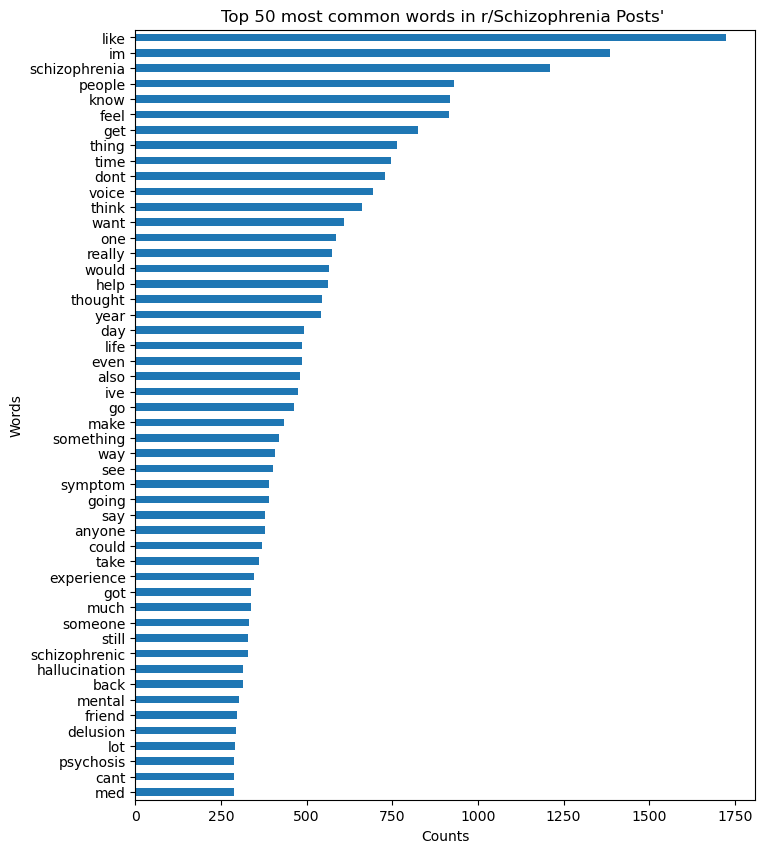

In [564]:
# preview the top 50 words with a bar chart

schizophrenia_df_cleaned_countvec_top50.sort_values(ascending=True).plot(kind='barh', figsize=(8,10))
plt.ylabel('Words')
plt.xlabel('Counts')
plt.title('Top 50 most common words in r/Schizophrenia Posts\' ')
plt.show()

In [565]:
# exporting token list to csv for reference
# schizophrenia_df_cleaned_countvec_all = schizophrenia_df_cleaned_countvec.sum().sort_values(ascending=False)
# schizophrenia_df_cleaned_countvec_all.to_csv('Count_Vectorizer_schizo_current_current.csv')

There are many irrelevant words like I, im etc. From the top 50 words, we will try to identify and remove as many irrelevant and common words as possible. We will also remove the words like "schizophrenia" and "bipolar" as they are directly related to the topics. 

We will then look at the revised top 50 words to make further judgement.

In [566]:
# List the words that we want to remove
# irrelevant_words = ['schizophrenia', 'bipolar', 'i', 'people', 'know', 'feel', 'im', 'get', 'like', 'thing', 'similar', 'really', 'want', 'get', 
# 'also', 'new', 'think', 'year', 'dupe', 'one', 'help', 'time', 'dont', 'think', 'want', 'much', 'one', 'really', 'would', 'help', 'thought', 'year','day', 
# 'life', 'could', 'even', 'also', 'ive', 'go', 'make', 'something', 'way', 'see', 'going', 'say', 'anyone', 'could', 'take', 'got', 'much', 'someone', 'still', 
# 'schizophrenic', 'back', 'friend', 'lot', 'cant', 'med', 'started', 'need', 'month', 'since', 'never', 'good', 'even', 'anything', 'first', 'said', 'sometimes', 
# 'always', 'medication', 'bad', 'around', 'feeling', 'well', 'tell', 'work', 'diagnosed', 'diagnosis','today', 'everything', 'better', 'told', 'trying', 'guy', 'right', 
# 'person', 'else', 'ever', 'last', 'come', 'night', 'ago', 'doctor', 'made', 'sure', 'week', 'talking', 'everyone', 'away', 'getting', 'long', 'stop', 'keep', 
# 'taking','try', 'though', 'every', 'please', 'didnt', 'went', 'find', 'thinking', 'question', 'u','actually','thats','recently','may','two','maybe','some',]

# irrelevant_words = ['schizophrenia', 'bipolar', 'i','schizophrenic','u','xb','im','ive']


# List the words we want to include
relevant_words_schizo = ['viewed','voice','auditory','hallucination','channel','delusion','evil','belief','neighbor','visual','hearing','dopamine','olanzapine','youtube',
                         'psychosis','demon','link','video','male','loud','hear','brief','delusional','vision','paranoia','imagine','heard','strange','paranoid','police',
                         'spiritual','noise','character','psychotic','believed','individual','brother','topic','negative','reality','leg','real','dad','passed','door','god',
                         'memory','study','woman','sensation','white','wall','men','soul','view','connection','believe','information','head','name','walking','street',
                         'future','kill','touch','eye','father','research','symptom','cat','listen','movie','man','watch','dont','recovery','power','specific','conversation',
                         'mentioned','scary','violent','red','laugh','joke','ability','apartment','speaking','word','alot','free','saw','true','room','opinion','learn']

# # define the function to remove the words
# def remove_irrwords(tokenized_list):
#     text = [word for word in tokenized_list if word not in irrelevant_words]
#     return text

# define the function to include the words
def include_words(tokenized_list):
    text = [word for word in tokenized_list if word in relevant_words_schizo]
    return text


schizophrenia_df_cleaned['combined_field_nopunct_tokens_nostop_lem2'] = schizophrenia_df_cleaned['combined_field_nopunct_tokens_nostop_lem'].apply(include_words)

C:\Users\Jackson\AppData\Local\Temp\ipykernel_24788\2780170503.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  schizophrenia_df_cleaned['combined_field_nopunct_tokens_nostop_lem2'] = schizophrenia_df_cleaned['combined_field_nopunct_tokens_nostop_lem'].apply(include_words)


In [567]:
# vectorize for preview
schizophrenia_df_cleaned_countvec2 = make_count_vectorizer(schizophrenia_df_cleaned['combined_field_nopunct_tokens_nostop_lem2'])

# preview the top 50 words in schizophrenia after removal of words
schizophrenia_df_cleaned_countvec2_top50 = schizophrenia_df_cleaned_countvec2.sum().sort_values(ascending=False).head(50)
schizophrenia_df_cleaned_countvec2_top50

dont             730
voice            693
symptom          389
hallucination    315
delusion         294
psychosis        287
believe          248
hear             242
real             225
head             219
psychotic        170
heard            159
god              156
hearing          156
word             148
eye              134
video            128
reality          123
room             118
negative         115
paranoid         112
saw              101
youtube           93
brother           91
kill              85
memory            83
paranoia          80
dad               80
link              80
name              78
auditory          77
man               74
conversation      72
belief            71
true              71
character         70
free              66
research          66
woman             65
study             63
future            60
door              59
visual            58
strange           56
individual        56
delusional        55
watch             54
evil         

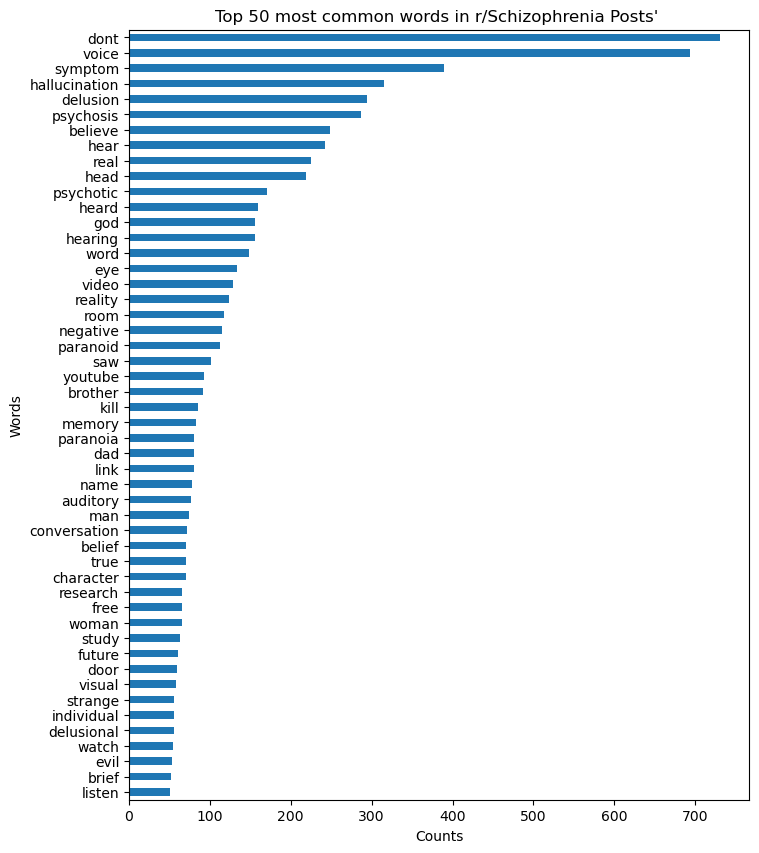

In [568]:
# preview the top 50 words with a bar chart after removal of words

schizophrenia_df_cleaned_countvec2_top50.sort_values(ascending=True).plot(kind='barh', figsize=(8,10))
plt.ylabel('Words')
plt.xlabel('Counts')
plt.title('Top 50 most common words in r/Schizophrenia Posts\' ')
plt.show()

### Zooming in on bipolar

In [569]:
bipolar_df_cleaned_countvec

,a,aa,aaaaaaahhhh,abandon,abandonable,abandoned,abandoning,abandonment,abandonned,abbreviated,...,ziprexa,zofran,zoloft,zombie,zone,zoo,zoom,zopiclone,zopiclones,zyprexa
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1621,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1622,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1623,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1624,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [570]:
# preview the top 50 words in bipolar
bipolar_df_cleaned_countvec_top50 = bipolar_df_cleaned_countvec.sum().sort_values(ascending=False).head(50)
bipolar_df_cleaned_countvec_top50

like          1862
im            1653
feel          1462
bipolar       1339
time          1080
get           1048
know          1015
year           790
day            789
want           783
really         780
thing          737
life           722
people         717
dont           715
one            677
think          632
even           628
would          619
med            604
episode        589
go             579
ive            574
going          557
work           553
make           537
help           501
manic          500
week           473
take           470
also           470
anyone         459
feeling        457
month          442
thought        427
got            427
much           426
something      421
medication     420
back           419
way            404
last           391
never          389
job            383
depression     381
need           376
good           374
still          374
friend         362
could          361
dtype: int64

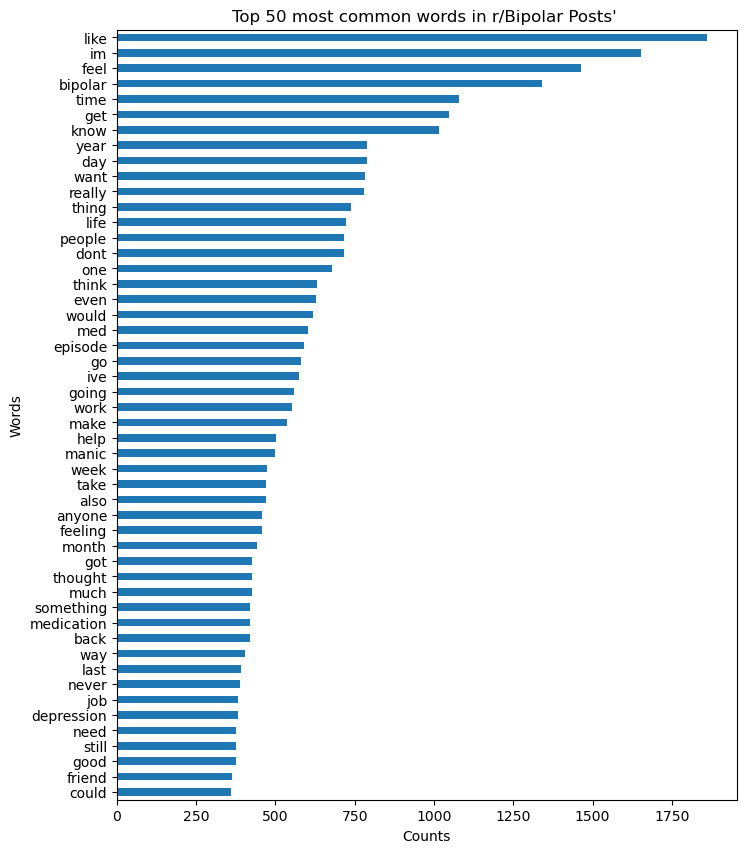

In [571]:
# preview the top 50 words with a bar chart

bipolar_df_cleaned_countvec_top50.sort_values(ascending=True).plot(kind='barh', figsize=(8,10))
plt.ylabel('Words')
plt.xlabel('Counts')
plt.title('Top 50 most common words in r/Bipolar Posts\' ')
plt.show()

In [572]:
# exporting token list to csv for reference
# bipolar_df_cleaned_countvec_all = bipolar_df_cleaned_countvec.sum().sort_values(ascending=False)
# bipolar_df_cleaned_countvec_all.to_csv('Count_Vectorizer_bipolar_current_current.csv')

We will repeat the same steps of removing irrelevant and common words for bipolar

In [573]:
relevant_words_bipolar = ['hypomania','hypomanic','lamictal','manic','mania','lithium','depressive','mixed','husband','swing','mood','depressed','proud','exhaustive',
                         'productive','shift','manage','spending','stable','seroquel','depression','episode','sex','drinking','insurance','appointment','job','emotionally',
                         'ptsd','boyfriend','adhd','ready','phase','adderall','miss','hit','slept','physically','plan','sleeping','schedule','sad','hobby','diagnosed','cycle','spent',
                         'date','medicated','public','latuda','bought','card','new','excited','fuck','yall','morning','team','week','antidepressant','hospitalized','bc',
                         'spend','mistake','breakdown','staying','reaction','work','prescribed','moved','incredibly','relationship','wife','lose','seriously','current','broke',
                         'terrible','amazing','summer','anger','therapy','therapist','healthy','struggling','psych','career','ton','personally','suicidal','med','pay','service',
                         'appreciated','coping']



# define the function to include the words
def include_words(tokenized_list):
    text = [word for word in tokenized_list if word in relevant_words_bipolar]
    return text

bipolar_df_cleaned['combined_field_nopunct_tokens_nostop_lem2'] = bipolar_df_cleaned['combined_field_nopunct_tokens_nostop_lem'].apply(include_words)

C:\Users\Jackson\AppData\Local\Temp\ipykernel_24788\4107838058.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bipolar_df_cleaned['combined_field_nopunct_tokens_nostop_lem2'] = bipolar_df_cleaned['combined_field_nopunct_tokens_nostop_lem'].apply(include_words)


In [574]:
# vectorize for preview
bipolar_df_cleaned_countvec2 = make_count_vectorizer(bipolar_df_cleaned['combined_field_nopunct_tokens_nostop_lem2'])

# preview the top 50 words in bipolar after removal of words
bipolar_df_cleaned_countvec2_top50 = bipolar_df_cleaned_countvec2.sum().sort_values(ascending=False).head(50)
bipolar_df_cleaned_countvec2_top50

med             604
episode         589
work            553
manic           500
week            472
job             383
depression      381
diagnosed       344
mood            299
mania           291
new             290
depressed       224
relationship    201
therapist       161
depressive      156
therapy         146
stable          126
hypomania       124
fuck            122
lithium         119
hypomanic       110
psych           107
morning         101
adhd            100
sad              90
mixed            89
plan             86
struggling       85
sleeping         82
husband          79
drinking         78
hit              78
appointment      78
sex              78
suicidal         76
lamictal         74
lose             73
spent            70
seroquel         65
swing            62
manage           60
pay              56
spend            56
bc               56
boyfriend        53
terrible         52
incredibly       51
ptsd             51
seriously        50
insurance        49


In [575]:
# exporting token list to csv after removal for reference
#bipolar_df_cleaned_countvec_all = bipolar_df_cleaned_countvec2.sum().sort_values(ascending=False)
#bipolar_df_cleaned_countvec_all.to_csv('Count_Vectorizer_bipolar_current_current_after_removal.csv')

In [576]:
# exporting token list to csv after removal for reference
#schizophrenia_df_cleaned_countvec_all = schizophrenia_df_cleaned_countvec2.sum().sort_values(ascending=False)
#schizophrenia_df_cleaned_countvec_all.to_csv('Count_Vectorizer_schizo_current_current_after_removal.csv')

Create Word Cloud for Schizophrenia

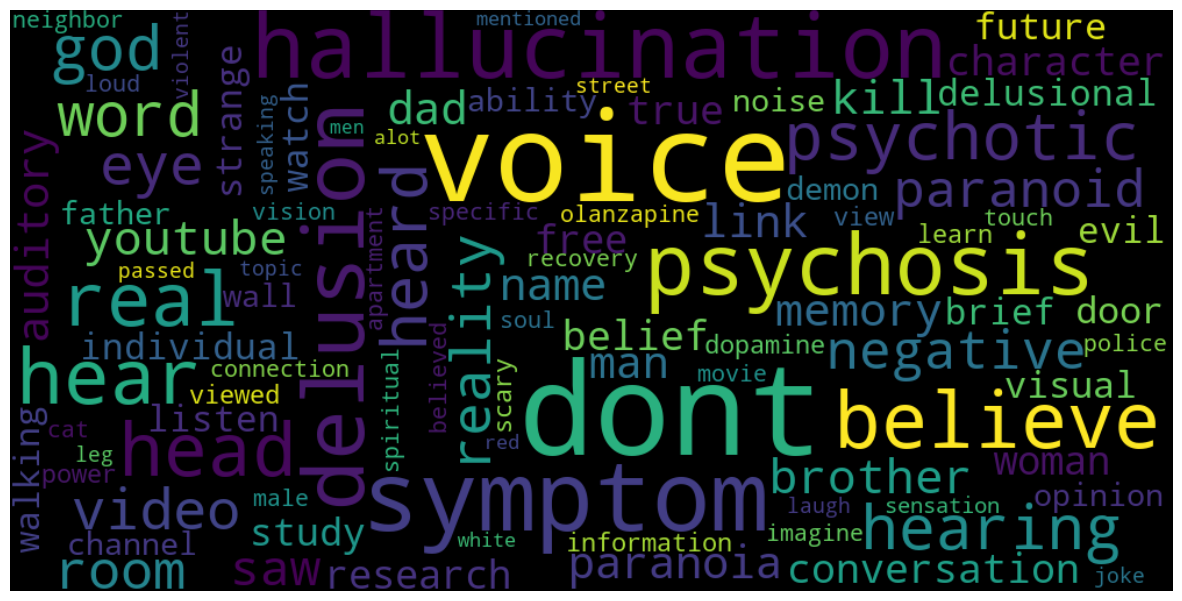

In [577]:
schizo_all_words = [word for tokens in schizophrenia_df_cleaned['combined_field_nopunct_tokens_nostop_lem2'] for word in tokens]
schizo_word_counts = Counter(schizo_all_words)
schizo_word_dict = dict(schizo_word_counts)
wordcloud = WordCloud(width = 1000, height = 500, random_state=21, max_font_size=110).generate_from_frequencies(schizo_word_dict)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Create Word Cloud for Bipolar

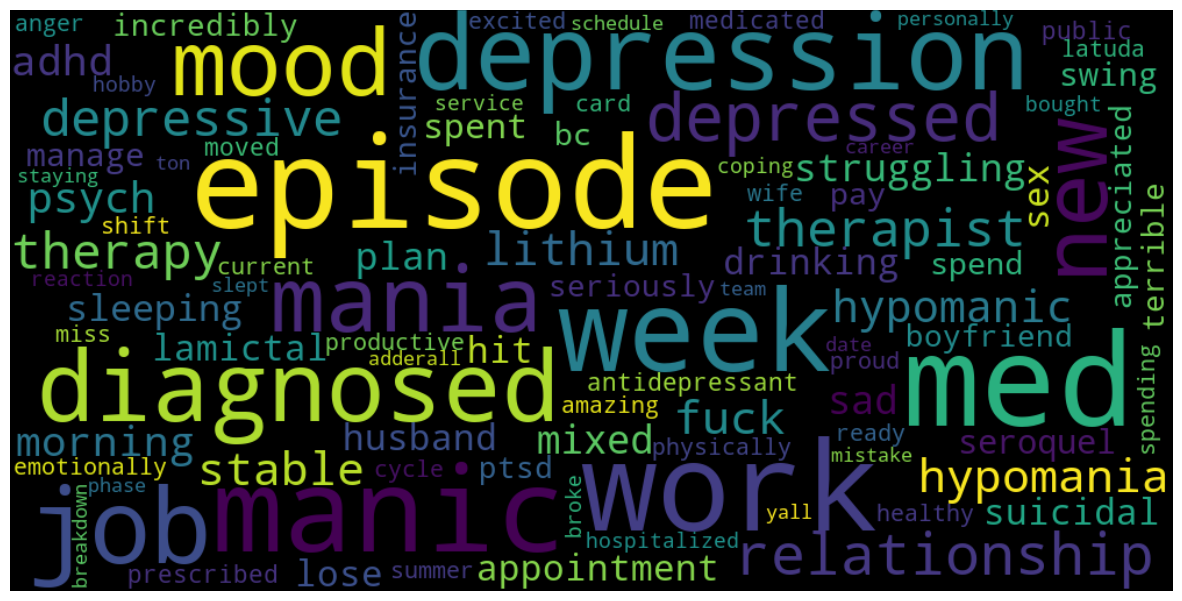

In [578]:
bipolar_all_words = [word for tokens in bipolar_df_cleaned['combined_field_nopunct_tokens_nostop_lem2'] for word in tokens]
bipolar_word_counts = Counter(bipolar_all_words)
bipolar_word_dict = dict(bipolar_word_counts)
wordcloud = WordCloud(width = 1000, height = 500, random_state=21, max_font_size=110).generate_from_frequencies(bipolar_word_dict)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Next, we will go in depth to look at pairs and trios of words with Ngram Vectorizer to see if there are any potential insights.

In [579]:

# Define function for N-Gram lemmatization
def lemmatizing_ngram(tokenized_text):
    # return string of all lemmatized words for their corresponding words in tokenized_text
    text = " ".join([wn.lemmatize(word) for word in tokenized_text])
    return text

# Lemmatize
schizophrenia_df_cleaned['combined_field_nopunct_tokens_nostop_lem3'] = schizophrenia_df_cleaned['combined_field_nopunct_tokens_nostop_lem2'].apply(
    lambda x: lemmatizing_ngram(x))
bipolar_df_cleaned['combined_field_nopunct_tokens_nostop_lem3'] = bipolar_df_cleaned['combined_field_nopunct_tokens_nostop_lem2'].apply(
    lambda x: lemmatizing_ngram(x))


# Define the function for making Ngram
def make_ngram(df,num):
    ngram_vect = CountVectorizer(ngram_range=(num,num))
    X_counts_ngram = ngram_vect.fit_transform(df)
    X_counts_df_ngram= pd.DataFrame(X_counts_ngram.toarray())
    X_counts_df_ngram.columns = ngram_vect.get_feature_names_out()
    
    return X_counts_df_ngram

C:\Users\Jackson\AppData\Local\Temp\ipykernel_24788\403162114.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  schizophrenia_df_cleaned['combined_field_nopunct_tokens_nostop_lem3'] = schizophrenia_df_cleaned['combined_field_nopunct_tokens_nostop_lem2'].apply(
C:\Users\Jackson\AppData\Local\Temp\ipykernel_24788\403162114.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bipolar_df_cleaned['combined_field_nopunct_tokens_nostop_lem3'] = bipolar_df_cleaned['combined_field_nopunct_tokens_nostop_lem2'].appl

### 2-Ngram for Schizophrenia

In [580]:
schizophrenia_df_cleaned_2ngram = make_ngram(schizophrenia_df_cleaned['combined_field_nopunct_tokens_nostop_lem3'],2)
schizophrenia_df_cleaned_2ngram

,ability ability,ability conversation,ability dont,ability evil,ability eye,ability free,ability learn,ability opinion,ability psychosis,ability psychotic,...,word youtube,youtube brother,youtube channel,youtube dad,youtube kill,youtube scary,youtube video,youtube walking,youtube word,youtube youtube
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1612,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1613,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1614,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [581]:
# preview the top 50 pairs of words in schizophrenia
schizophrenia_df_cleaned_2ngram_top50 = schizophrenia_df_cleaned_2ngram.sum().sort_values(ascending=False).head(50)
schizophrenia_df_cleaned_2ngram_top50

dont dont                      155
voice voice                    115
hearing voice                   80
hear voice                      74
voice head                      64
negative symptom                55
auditory hallucination          54
symptom symptom                 54
youtube video                   44
voice hear                      43
heard voice                     41
youtube channel                 41
delusion delusion               41
video link                      40
brief viewed                    38
link youtube                    38
video brief                     38
channel video                   36
visual hallucination            34
psychosis psychosis             34
voice dont                      33
dont believe                    32
hallucination hallucination     31
symptom dont                    31
dont voice                      30
word word                       29
hallucination delusion          27
psychotic symptom               27
delusion hallucinati

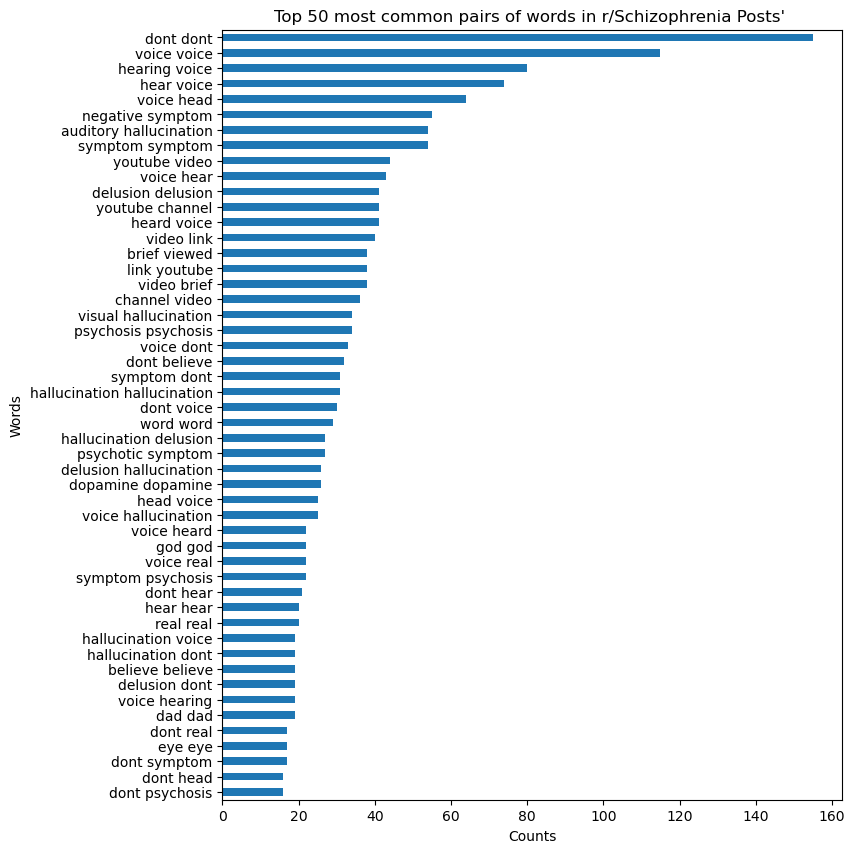

In [582]:
# preview the top 50 words with a bar chart

schizophrenia_df_cleaned_2ngram_top50.sort_values(ascending=True).plot(kind='barh', figsize=(8,10))
plt.ylabel('Words')
plt.xlabel('Counts')
plt.title('Top 50 most common pairs of words in r/Schizophrenia Posts\' ')
plt.show()

Pairs of words make sense

### 3-Ngram for Schizophrenia

In [583]:
schizophrenia_df_cleaned_3ngram = make_ngram(schizophrenia_df_cleaned['combined_field_nopunct_tokens_nostop_lem3'],3)
schizophrenia_df_cleaned_3ngram

,ability ability reality,ability ability topic,ability ability word,ability conversation believed,ability dont connection,ability dont dont,ability dont opinion,ability dont real,ability evil believe,ability eye ability,...,youtube kill reality,youtube video evil,youtube video individual,youtube video link,youtube video passed,youtube video reality,youtube video youtube,youtube walking dont,youtube word voice,youtube youtube walking
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1612,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1613,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1614,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [584]:
# preview the top 50 trio of words in schizophrenia
schizophrenia_df_cleaned_3ngram_top50 = schizophrenia_df_cleaned_3ngram.sum().sort_values(ascending=False).head(50)
schizophrenia_df_cleaned_3ngram_top50

video brief viewed                      38
youtube video link                      38
link youtube channel                    38
dont dont dont                          38
video link youtube                      38
channel video brief                     36
youtube channel video                   36
voice voice voice                       22
dopamine dopamine dopamine              21
voice hear voice                        19
voice head voice                        16
voice hearing voice                     14
word word word                          14
hear voice hear                         13
symptom negative symptom                13
dont hear voice                         13
hearing voice voice                     13
hear voice voice                        12
voice heard voice                       11
symptom symptom symptom                 11
voice voice head                        11
hearing voice hearing                    9
voice dont voice                         9
hallucinati

### 2-Ngram for Bipolar

In [585]:
bipolar_df_cleaned_2ngram = make_ngram(bipolar_df_cleaned['combined_field_nopunct_tokens_nostop_lem3'],2)
bipolar_df_cleaned_2ngram

,adderall adderall,adderall adhd,adderall anger,adderall broke,adderall depression,adderall depressive,adderall manic,adderall med,adderall miss,adderall mood,...,yall diagnosed,yall fuck,yall manage,yall manic,yall med,yall medicated,yall sleeping,yall therapy,yall week,yall yall
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1621,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1622,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1623,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1624,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [586]:
# preview the top 50 pairs of words in bipolar
bipolar_df_cleaned_2ngram_top50 = bipolar_df_cleaned_2ngram.sum().sort_values(ascending=False).head(50)
bipolar_df_cleaned_2ngram_top50

manic episode                157
med med                      100
depressive episode            99
job job                       70
work work                     69
manic manic                   60
work job                      55
mood swing                    51
job work                      45
episode episode               43
mixed episode                 43
week week                     41
depression depression         40
relationship relationship     39
work week                     36
mania mania                   36
med work                      36
episode manic                 33
week work                     32
new new                       30
lithium lithium               30
mood mood                     27
new job                       27
depression mania              27
med week                      27
episode week                  26
fuck fuck                     25
episode work                  24
diagnosed diagnosed           24
diagnosed manic               23
depressed 

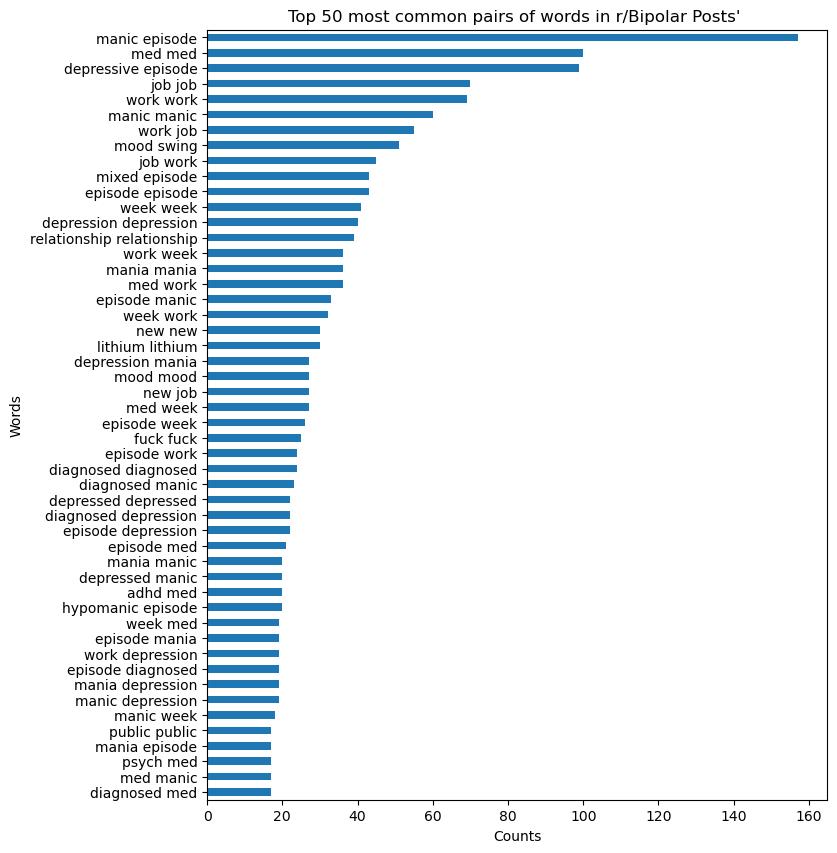

In [587]:
# preview the top 50 words with a bar chart

bipolar_df_cleaned_2ngram_top50.sort_values(ascending=True).plot(kind='barh', figsize=(8,10))
plt.ylabel('Words')
plt.xlabel('Counts')
plt.title('Top 50 most common pairs of words in r/Bipolar Posts\' ')
plt.show()

Pairs of words make sense

### 3-Ngram for Bipolar

In [588]:
bipolar_df_cleaned_3ngram = make_ngram(bipolar_df_cleaned['combined_field_nopunct_tokens_nostop_lem3'],3)
bipolar_df_cleaned_3ngram

,adderall adderall manic,adderall adderall personally,adderall adhd med,adderall anger suicidal,adderall broke moved,adderall depression adderall,adderall manic depression,adderall manic episode,adderall med adderall,adderall miss drinking,...,yall diagnosed struggling,yall fuck fuck,yall med lose,yall med med,yall med plan,yall medicated work,yall sleeping med,yall therapy lose,yall week seriously,yall yall diagnosed
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1621,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1622,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1623,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1624,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [589]:
# preview the top 50 trio of words in schizophrenia
bipolar_df_cleaned_3ngram_top50 = bipolar_df_cleaned_3ngram.sum().sort_values(ascending=False).head(50)
bipolar_df_cleaned_3ngram_top50

med med med                               19
job job job                               18
work work work                            17
manic episode manic                       17
episode manic episode                     16
work job work                             16
diagnosed manic episode                   16
fuck fuck fuck                            13
episode depressive episode                12
manic manic manic                         11
public public public                      11
lithium lithium lithium                   11
job work job                              11
depression depression depression          10
mood swing mood                           10
episode mixed episode                      9
med manic episode                          9
relationship relationship relationship     9
week depressive episode                    8
job work work                              8
manic episode week                         8
manic episode diagnosed                    8
episode ep

2-Ngrams appear to make more sense than 3-Ngrams for Schizophrenia and Bipolar posts

## Modelling

Next, we will begin to create models and see their scores

- Count Vectorizer - Naive Bayes Bernouli
- Count Vectorizer - Naive Bayes Multinomial
- Count Vectorizer - Logistic Regression
- BiGram - Naive Bayes Bernouli
- BiGram - Naive Bayes Multinomial
- BiGram - Logistic Regression
- TF-IDF - Naive Bayes Bernouli
- TF-IDF - Naive Bayes Multinomial
- TF-IDF - Logistic Regression

Preparation work before modelling

In [590]:
# Merge the schizophrenia and bipolar dataframes back together

combined_df_cleaned3 = pd.concat([schizophrenia_df_cleaned, bipolar_df_cleaned])
combined_df_cleaned3

,id,title,text,score,comments_count,author,created_utc,gilding,combined_field,label,combined_field_nopunct,combined_field_nopunct_tokens,combined_field_nopunct_tokens_nostop,combined_field_nopunct_tokens_nostop_lem,combined_field_nopunct_tokens_nostop_lem2,combined_field_nopunct_tokens_nostop_lem3
0,53xfmu,Frequently Asked Questions (Read This Sticky),Welcome to [/r/schizophrenia](https://www.redd...,44,7,soundandvisions,1.474520e+09,0,Frequently Asked Questions (Read This Sticky) ...,0,Frequently Asked Questions Read This Sticky We...,"[frequently, asked, questions, read, this, sti...","[frequently, asked, questions, read, sticky, w...","[frequently, asked, question, read, sticky, we...","[free, topic, link, symptom, specific, symptom...",free topic link symptom specific symptom chara...
1,13tlqzi,Some art I’ve done.,Some art I’ve done in the past few weeks.,68,24,girludreamedof,1.685231e+09,0,Some art I’ve done. Some art I’ve done in the ...,0,Some art I’ve done Some art I’ve done in the p...,"[some, art, i, ve, done, some, art, i, ve, don...","[art, done, art, done, past, weeks]","[art, done, art, done, past, week]",[],
2,13tibcc,Hospital/psych ward art,Here’s two of my drawings from when I was in t...,98,4,thiccpotatochipp,1.685222e+09,0,Hospital/psych ward art Here’s two of my drawi...,0,Hospitalpsych ward art Here’s two of my drawin...,"[hospitalpsych, ward, art, here, s, two, of, m...","[hospitalpsych, ward, art, two, drawings, hosp...","[hospitalpsych, ward, art, two, drawing, hospi...",[],
3,13tmt0l,Fear that suicide is my destiny,As a kid I would get this sick feeling in my g...,36,16,Zealousideal_Fly6576,1.685234e+09,0,Fear that suicide is my destiny As a kid I wou...,0,Fear that suicide is my destiny As a kid I wou...,"[fear, that, suicide, is, my, destiny, as, a, ...","[fear, suicide, destiny, kid, would, get, sick...","[fear, suicide, destiny, kid, would, get, sick...","[dont, hearing, heard, voice, head, psychosis,...",dont hearing heard voice head psychosis walkin...
4,13tkfru,If this disease is incurable and Kan will fore...,Don’t think he wants to continue to live. Wont...,20,15,Professional-Pay6804,1.685227e+09,0,If this disease is incurable and Kan will fore...,0,If this disease is incurable and Kan will fore...,"[if, this, disease, is, incurable, and, kan, w...","[disease, incurable, kan, forever, like, think...","[disease, incurable, kan, forever, like, think...",[],
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3237,dbyed4,I did a thing!,"I threw out my ""just in case pills."" It was a ...",786,70,SassBHW,1.569958e+09,0,"I did a thing! I threw out my ""just in case pi...",1,I did a thing I threw out my just in case pill...,"[i, did, a, thing, i, threw, out, my, just, in...","[thing, threw, case, pills, huge, bottle, left...","[thing, threw, case, pill, huge, bottle, lefto...",[proud],proud
3238,k4gor5,(hypo)mania and depression aren't just intense...,I started Lamictal a couple months ago and thi...,768,71,fighterpilot909,1.606810e+09,0,(hypo)mania and depression aren't just intense...,1,hypomania and depression arent just intense ve...,"[hypomania, and, depression, arent, just, inte...","[hypomania, depression, arent, intense, versio...","[hypomania, depression, arent, intense, versio...","[hypomania, depression, lamictal, stable, sad,...",hypomania depression lamictal stable sad sad d...
3239,ig43dn,i fucking got in to grad school guys,i was cycling really hard my entire undergradu...,771,54,somethingsophie,1.598325e+09,0,i fucking got in to grad school guys i was cyc...,1,i fucking got in to grad school guys i was cyc...,"[i, fucking, got, in, to, grad, school, guys, ...","[fucking, got, grad, school, guys, cycling, re...","[fucking, got, grad, school, guy, cycling, rea...",[career],career
3240,lb1ouw,My semester GPA is 4.00!,My hands are shaking and I am in complete disb...,762,73,BipolarMindAtNotEase,1.612288e+09,0,My semester GPA is 4.00! My hands are shaking ...,1,My semester

In [ ]:
combined_df_cleaned3.to_csv('Count_Vectorizer_schizo_current_current_after_removal.csv')

Rows are back to 3242 as in combined_df

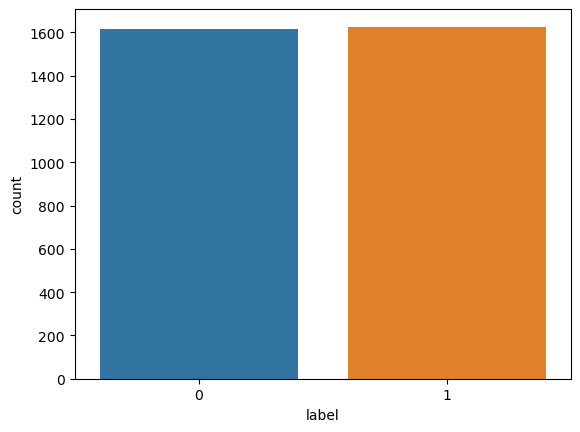

In [591]:
# Check that there are only 2 classes of values for target variable ('0' for schizophrenia and '1' for bipolar)
label_categories = sns.countplot(x='label', data=combined_df_cleaned3);

In [592]:
combined_df_cleaned3_countvectorizer = make_count_vectorizer(combined_df_cleaned3['combined_field_nopunct_tokens_nostop_lem2'])

# Adding the label column
combined_df_cleaned3_countvectorizer['label'] = combined_df_cleaned3['label']
combined_df_cleaned3_countvectorizer

,ability,adderall,adhd,alot,amazing,anger,antidepressant,apartment,appointment,appreciated,...,watch,week,white,wife,woman,word,work,yall,youtube,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3237,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3238,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3239,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3240,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [593]:
combined_df_cleaned3_countvectorizer.loc[:, combined_df_cleaned3_countvectorizer.columns!='label']

,ability,adderall,adhd,alot,amazing,anger,antidepressant,apartment,appointment,appreciated,...,wall,watch,week,white,wife,woman,word,work,yall,youtube
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3237,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3238,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3239,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3240,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [594]:
combined_df_cleaned3_countvectorizer.loc[:, combined_df_cleaned3_countvectorizer.columns=='label'] 

,label
0,0
1,0
2,0
3,0
4,0
...,...
3237,1
3238,1
3239,1
3240,1


Train-test-split

In [595]:
# Define X and y
X = combined_df_cleaned3_countvectorizer.loc[:, combined_df_cleaned3_countvectorizer.columns!='label']
y = combined_df_cleaned3_countvectorizer.loc[:, combined_df_cleaned3_countvectorizer.columns=='label'] 

# Train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=69)

- Count Vectorizer - Naive Bayes Bernouli

In [596]:
# Training the Bernoulli Model
BernNB = BernoulliNB(binarize=0.1)
BernNB.fit(X_train, y_train)

# Predicting the results using the X_train and X_test
y_pred_train = BernNB.predict(X_train)
y_pred_test = BernNB.predict(X_test)

# Saving the train and test scores
cv_nb_bernouli_train_score = accuracy_score(y_train, y_pred_train)
cv_nb_bernouli_test_score = accuracy_score(y_test, y_pred_test)

# Displaying the train and test scores
print("Accuracy Scores for the Count Vectorizer - Naive Bayes Bernouli model:")
print(f"Count Vectorizer - Naive Bayes Bernouli Train Score: {round(cv_nb_bernouli_train_score,4)}")
print(f"Count Vectorizer - Naive Bayes Bernouli Test Score: {round(cv_nb_bernouli_test_score,4)}")

Accuracy Scores for the Count Vectorizer - Naive Bayes Bernouli model:
Count Vectorizer - Naive Bayes Bernouli Train Score: 0.9465
Count Vectorizer - Naive Bayes Bernouli Test Score: 0.9519


c:\Users\Jackson\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [597]:
# Display Classification Metrics
print("Count Vectorizer - Naive Bayes Bernouli Classification Report:")
print(classification_report(y_test, y_pred_test))

Count Vectorizer - Naive Bayes Bernouli Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       411
           1       1.00      0.90      0.95       400

    accuracy                           0.95       811
   macro avg       0.96      0.95      0.95       811
weighted avg       0.96      0.95      0.95       811



- Count Vectorizer - Naive Bayes Multinomial

In [598]:
# Training the Multinomial Model
MultiNB = MultinomialNB()
MultiNB.fit(X_train, y_train)

# Predicting the results using the X_train and X_test
y_pred_train = MultiNB.predict(X_train)
y_pred_test = MultiNB.predict(X_test)

# Saving the train and test scores
cv_nb_multinomial_train_score = accuracy_score(y_train, y_pred_train)
cv_nb_multinomial_test_score = accuracy_score(y_test, y_pred_test)

# Displaying the train and test scores
print("Accuracy Scores for the Count Vectorizer - Naive Bayes Multinomial model:")
print(f"Count Vectorizer - Naive Bayes Multinomial Train Score: {round(cv_nb_multinomial_train_score,4)}")
print(f"Count Vectorizer - Naive Bayes Multinomial Test Score: {round(cv_nb_multinomial_test_score,4)}")

Accuracy Scores for the Count Vectorizer - Naive Bayes Multinomial model:
Count Vectorizer - Naive Bayes Multinomial Train Score: 0.9033
Count Vectorizer - Naive Bayes Multinomial Test Score: 0.8927


c:\Users\Jackson\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [599]:
# Display Classification Metrics
print("Count Vectorizer - Naive Bayes Multinomial Classification Report:")
print(classification_report(y_test, y_pred_test))

Count Vectorizer - Naive Bayes Multinomial Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.79      0.88       411
           1       0.82      1.00      0.90       400

    accuracy                           0.89       811
   macro avg       0.91      0.89      0.89       811
weighted avg       0.91      0.89      0.89       811



- Count Vectorizer - Logistic Regression

In [600]:
LogReg = LogisticRegression(solver='liblinear')
LogReg.fit(X_train, y_train)

# Predicting the results using the X_train and X_test
y_pred_train = LogReg.predict(X_train)
y_pred_test = LogReg.predict(X_test)

# Saving the train and test scores
cv_logreg_train_score = accuracy_score(y_train, y_pred_train)
cv_logreg_test_score = accuracy_score(y_test, y_pred_test)

# Displaying the train and test scores
print("Accuracy Scores for the Count Vectorizer - Logistic Regression model:")
print(f"Count Vectorizer - Logistic Regression Train Score: {round(cv_logreg_train_score,4)}")
print(f"Count Vectorizer - Logistic Regression Test Score: {round(cv_logreg_test_score,4)}")

Accuracy Scores for the Count Vectorizer - Logistic Regression model:
Count Vectorizer - Logistic Regression Train Score: 0.9465
Count Vectorizer - Logistic Regression Test Score: 0.9457


c:\Users\Jackson\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [601]:
# Display Classification Metrics
print("Count Vectorizer - Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_test))

Count Vectorizer - Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       411
           1       1.00      0.89      0.94       400

    accuracy                           0.95       811
   macro avg       0.95      0.95      0.95       811
weighted avg       0.95      0.95      0.95       811



Preparing the dataset for 2-Ngram Vectorization

In [602]:
combined_df_cleaned3_2ngram = make_ngram(combined_df_cleaned3['combined_field_nopunct_tokens_nostop_lem3'],2)
combined_df_cleaned3_2ngram['label'] = combined_df_cleaned3['label']

In [603]:
# Define X and y
X = combined_df_cleaned3_2ngram.loc[:, combined_df_cleaned3_2ngram.columns!='label']
y = combined_df_cleaned3_2ngram.loc[:, combined_df_cleaned3_2ngram.columns=='label'] 

# Train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=69)

- BiGram - Naive Bayes Bernouli

In [604]:
# Training the Bernoulli Model
BernNB = BernoulliNB(binarize=0.1)
BernNB.fit(X_train, y_train)

# Predicting the results using the X_train and X_test
y_pred_train = BernNB.predict(X_train)
y_pred_test = BernNB.predict(X_test)

# Saving the train and test scores
ngram2_nb_bernouli_train_score = accuracy_score(y_train, y_pred_train)
ngram2_nb_bernouli_test_score = accuracy_score(y_test, y_pred_test)

# Displaying the train and test scores
print("Accuracy Scores for the 2Ngram - Naive Bayes Bernouli model:")
print(f"2Ngram - Naive Bayes Bernouli Train Score: {round(ngram2_nb_bernouli_train_score,4)}")
print(f"2Ngram - Naive Bayes Bernouli Test Score: {round(ngram2_nb_bernouli_test_score,4)}")

c:\Users\Jackson\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Scores for the 2Ngram - Naive Bayes Bernouli model:
2Ngram - Naive Bayes Bernouli Train Score: 0.8926
2Ngram - Naive Bayes Bernouli Test Score: 0.8668


In [605]:
# Display Classification Metrics
print("Count Vectorizer - 2Ngram Naive Bayes Bernouli Classification Report:")
print(classification_report(y_test, y_pred_test))

Count Vectorizer - 2Ngram Naive Bayes Bernouli Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       411
           1       1.00      0.73      0.84       400

    accuracy                           0.87       811
   macro avg       0.90      0.86      0.86       811
weighted avg       0.89      0.87      0.86       811



- Bigram Naive Bayes Multinomial

In [606]:
# Training the Multinomial Model
MultiNB = MultinomialNB()
MultiNB.fit(X_train, y_train)

# Predicting the results using the X_train and X_test
y_pred_train = MultiNB.predict(X_train)
y_pred_test = MultiNB.predict(X_test)

# Saving the train and test scores
ngram2_nb_multinomial_train_score = accuracy_score(y_train, y_pred_train)
ngram2_nb_multinomial_test_score = accuracy_score(y_test, y_pred_test)

# Displaying the train and test scores
print("Accuracy Scores for the 2Ngram - Naive Bayes Multinomial model:")
print(f"2Ngram - Naive Bayes Multinomial Train Score: {round(ngram2_nb_multinomial_train_score,4)}")
print(f"2Ngram - Naive Bayes Multinomial Test Score: {round(ngram2_nb_multinomial_test_score,4)}")

Accuracy Scores for the 2Ngram - Naive Bayes Multinomial model:
2Ngram - Naive Bayes Multinomial Train Score: 0.8334
2Ngram - Naive Bayes Multinomial Test Score: 0.7941


c:\Users\Jackson\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [607]:
# Display Classification Metrics
print("3Ngram - Naive Bayes Multinomial Classification Report:")
print(classification_report(y_test, y_pred_test))

3Ngram - Naive Bayes Multinomial Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.63      0.76       411
           1       0.72      0.96      0.82       400

    accuracy                           0.79       811
   macro avg       0.83      0.80      0.79       811
weighted avg       0.83      0.79      0.79       811



- Bigram Logistic Regression

In [608]:
LogReg = LogisticRegression(solver='liblinear')
LogReg.fit(X_train, y_train)

# Predicting the results using the X_train and X_test
y_pred_train = LogReg.predict(X_train)
y_pred_test = LogReg.predict(X_test)

# Saving the train and test scores
ngram2_logreg_train_score = accuracy_score(y_train, y_pred_train)
ngram2_logreg_test_score = accuracy_score(y_test, y_pred_test)

# Displaying the train and test scores
print("Accuracy Scores for the Count Vectorizer - Logistic Regression model:")
print(f"2Ngram - Logistic Regression Train Score: {round(ngram2_logreg_train_score,4)}")
print(f"2Ngram - Logistic Regression Test Score: {round(ngram2_logreg_test_score,4)}")

c:\Users\Jackson\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Scores for the Count Vectorizer - Logistic Regression model:
2Ngram - Logistic Regression Train Score: 0.8926
2Ngram - Logistic Regression Test Score: 0.836


Preparing the dataset for 3-Ngram Vectorization

In [609]:
# combined_df_cleaned3_3ngram = make_ngram(combined_df_cleaned3['combined_field_nopunct_tokens_nostop_lem3'],3)
# combined_df_cleaned3_3ngram['label'] = combined_df_cleaned3['label']

In [610]:
# # Define X and y
# X = combined_df_cleaned3_3ngram.loc[:, combined_df_cleaned3_3ngram.columns!='label']
# y = combined_df_cleaned3_3ngram.loc[:, combined_df_cleaned3_3ngram.columns=='label'] 

# # Train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=69)

- TriGram - Naive Bayes Bernouli

In [611]:
# # Training the Bernoulli Model
# BernNB = BernoulliNB(binarize=0.1)
# BernNB.fit(X_train, y_train)

# # Predicting the results using the X_train and X_test
# y_pred_train = BernNB.predict(X_train)
# y_pred_test = BernNB.predict(X_test)

# # Saving the train and test scores
# ngram3_nb_bernouli_train_score = accuracy_score(y_train, y_pred_train)
# ngram3_nb_bernouli_test_score = accuracy_score(y_test, y_pred_test)

# # Displaying the train and test scores
# print("Accuracy Scores for the 2Ngram - Naive Bayes Bernouli model:")
# print(f"3Ngram - Naive Bayes Bernouli Train Score: {round(ngram3_nb_bernouli_train_score,4)}")
# print(f"3Ngram - Naive Bayes Bernouli Test Score: {round(ngram3_nb_bernouli_test_score,4)}")

In [612]:
# Display Classification Metrics
#print("Count Vectorizer - 3Ngram Naive Bayes Bernouli Classification Report:")
#print(classification_report(y_test, y_pred_test))

Define the function for TF-IDF

In [613]:
def make_tfidf(df):
    tfidf_vect = TfidfVectorizer(analyzer = lemmatizing)
    X_tfidf = tfidf_vect.fit_transform(df)
    X_tfidf_df = pd.DataFrame(X_tfidf.toarray())
    X_tfidf_df.columns = tfidf_vect.get_feature_names_out()
    return X_tfidf_df

Preparing the dataset for TFIDF

In [614]:
combined_df_cleaned3_tfidf = make_tfidf(combined_df_cleaned3['combined_field_nopunct_tokens_nostop_lem2'])
combined_df_cleaned3_tfidf['label'] = combined_df_cleaned3['label']
combined_df_cleaned3_tfidf

,ability,adderall,adhd,alot,amazing,anger,antidepressant,apartment,appointment,appreciated,...,watch,week,white,wife,woman,word,work,yall,youtube,label
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3237,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1
3238,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1
3239,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1
3240,0.0,0.0,0.332464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.228665,0.0,0.0,1


In [615]:
# Define X and y
X = combined_df_cleaned3_tfidf.loc[:, combined_df_cleaned3_tfidf.columns!='label']
y = combined_df_cleaned3_tfidf.loc[:, combined_df_cleaned3_tfidf.columns=='label'] 

# Train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=69)

- TF-IDF Naive Bayes Bernouli

In [616]:
# Training the Bernoulli Model
BernNB = BernoulliNB(binarize=0.1)
BernNB.fit(X_train, y_train)

# Predicting the results using the X_train and X_test
y_pred_train = BernNB.predict(X_train)
y_pred_test = BernNB.predict(X_test)

# Saving the train and test scores
tfidf_nb_bernouli_train_score = accuracy_score(y_train, y_pred_train)
tfidf_nb_bernouli_test_score = accuracy_score(y_test, y_pred_test)

# Displaying the train and test scores
print("Accuracy Scores for the TFIDF - Naive Bayes Bernouli model:")
print(f"TFIDF - Naive Bayes Bernouli Train Score: {round(tfidf_nb_bernouli_train_score,4)}")
print(f"TFIDF - Naive Bayes Bernouli Test Score: {round(tfidf_nb_bernouli_test_score,4)}")

Accuracy Scores for the TFIDF - Naive Bayes Bernouli model:
TFIDF - Naive Bayes Bernouli Train Score: 0.9465
TFIDF - Naive Bayes Bernouli Test Score: 0.9519


c:\Users\Jackson\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [617]:
# Display Classification Metrics
print("TFIDF - Naive Bayes Bernouli Classification Report:")
print(classification_report(y_test, y_pred_test))

TFIDF - Naive Bayes Bernouli Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       411
           1       1.00      0.90      0.95       400

    accuracy                           0.95       811
   macro avg       0.96      0.95      0.95       811
weighted avg       0.96      0.95      0.95       811



- TFIDF Naive Bayes Multinomial

In [618]:
# Training the Multinomial Model
MultiNB = MultinomialNB()
MultiNB.fit(X_train, y_train)

# Predicting the results using the X_train and X_test
y_pred_train = MultiNB.predict(X_train)
y_pred_test = MultiNB.predict(X_test)

# Saving the train and test scores
tfidf_nb_multinomial_train_score = accuracy_score(y_train, y_pred_train)
tfidf_nb_multinomial_test_score = accuracy_score(y_test, y_pred_test)

# Displaying the train and test scores
print("Accuracy Scores for the 2Ngram - Naive Bayes Multinomial model:")
print(f"TFIDF - Naive Bayes Multinomial Train Score: {round(tfidf_nb_multinomial_train_score,4)}")
print(f"TFIDF - Naive Bayes Multinomial Test Score: {round(tfidf_nb_multinomial_test_score,4)}")

Accuracy Scores for the 2Ngram - Naive Bayes Multinomial model:
TFIDF - Naive Bayes Multinomial Train Score: 0.9033
TFIDF - Naive Bayes Multinomial Test Score: 0.8927


c:\Users\Jackson\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [619]:
# Display Classification Metrics
print("TFIDF - Naive Bayes Multinomial Classification Report:")
print(classification_report(y_test, y_pred_test))

TFIDF - Naive Bayes Multinomial Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.79      0.88       411
           1       0.82      1.00      0.90       400

    accuracy                           0.89       811
   macro avg       0.91      0.89      0.89       811
weighted avg       0.91      0.89      0.89       811



- TFIDF Logistic Regression

In [620]:
LogReg = LogisticRegression(solver='liblinear')
LogReg.fit(X_train, y_train)

# Predicting the results using the X_train and X_test
y_pred_train = LogReg.predict(X_train)
y_pred_test = LogReg.predict(X_test)

# Saving the train and test scores
tfidf_logreg_train_score = accuracy_score(y_train, y_pred_train)
tfidf_logreg_test_score = accuracy_score(y_test, y_pred_test)

# Displaying the train and test scores
print("Accuracy Scores for the Count Vectorizer - Logistic Regression model:")
print(f"TFIDF- Logistic Regression Train Score: {round(tfidf_logreg_train_score,4)}")
print(f"TFIDF - Logistic Regression Test Score: {round(tfidf_logreg_test_score,4)}")

Accuracy Scores for the Count Vectorizer - Logistic Regression model:
TFIDF- Logistic Regression Train Score: 0.9465
TFIDF - Logistic Regression Test Score: 0.9482


c:\Users\Jackson\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [621]:
# Display Classification Metrics
print("TFIDF - Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_test))

TFIDF - Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       411
           1       1.00      0.90      0.94       400

    accuracy                           0.95       811
   macro avg       0.95      0.95      0.95       811
weighted avg       0.95      0.95      0.95       811



- Random Forest Count Vectorizer

In [622]:
# Define X and y
X = combined_df_cleaned3_countvectorizer.loc[:, combined_df_cleaned3_countvectorizer.columns!='label']
y = combined_df_cleaned3_countvectorizer.loc[:, combined_df_cleaned3_countvectorizer.columns=='label'] 

# Train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=69)

In [623]:
classifier = RandomForestClassifier(n_estimators=1000, random_state=69)
classifier.fit(X_train, y_train)

# Predicting the results using the X_train and X_test
y_pred_train = classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)

# Saving the train and test scores
randomforest_train_score = accuracy_score(y_train, y_pred_train)
randomforest_test_score = accuracy_score(y_test, y_pred_test)

# Displaying the train and test scores
print("Accuracy Scores for the Random Forest model:")
print(f"Random Forest Train Score: {round(randomforest_train_score,4)}")
print(f"Random Forest  Test Score: {round(randomforest_test_score,4)}")

C:\Users\Jackson\AppData\Local\Temp\ipykernel_24788\4152475654.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X_train, y_train)


Accuracy Scores for the Random Forest model:
Random Forest Train Score: 0.9465
Random Forest  Test Score: 0.9433


In [624]:
# Display Classification Metrics
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_test))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       411
           1       1.00      0.89      0.94       400

    accuracy                           0.94       811
   macro avg       0.95      0.94      0.94       811
weighted avg       0.95      0.94      0.94       811



- Adaboost Count Vectorizer

In [625]:
clf = AdaBoostClassifier(n_estimators=100)
clf.fit(X_train, y_train)

# Predicting the results using the X_train and X_test
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

# Saving the train and test scores
adaboost_train_score = accuracy_score(y_train, y_pred_train)
adaboost_test_score = accuracy_score(y_test, y_pred_test)

# Displaying the train and test scores
print("Accuracy Scores for the Adaptive Boosting model:")
print(f"Adaptive Boosting Train Score: {round(adaboost_train_score,4)}")
print(f"Adaptive Boosting Test Score: {round(adaboost_test_score,4)}")

c:\Users\Jackson\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Scores for the Adaptive Boosting model:
Adaptive Boosting Train Score: 0.9412
Adaptive Boosting Test Score: 0.9359


In [626]:
# Display Classification Metrics
print("Adaptive Boosting Classification Report:")
print(classification_report(y_test, y_pred_test))

Adaptive Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       411
           1       1.00      0.87      0.93       400

    accuracy                           0.94       811
   macro avg       0.94      0.94      0.94       811
weighted avg       0.94      0.94      0.94       811



- Gradient Boost Count Vectorizer

In [627]:
clf_gradientboost = GradientBoostingClassifier(n_estimators=100)
clf_gradientboost.fit(X_train, y_train)

# Predicting the results using the X_train and X_test
y_pred_train = clf_gradientboost.predict(X_train)
y_pred_test = clf_gradientboost.predict(X_test)

# Saving the train and test scores
gradientboost_train_score = accuracy_score(y_train, y_pred_train)
gradientboost_test_score = accuracy_score(y_test, y_pred_test)

# Displaying the train and test scores
print("Accuracy Scores for the Gradient Boosting model:")
print(f"Gradient Boosting Train Score: {round(gradientboost_train_score,4)}")
print(f"Gradient Boosting Test Score: {round(gradientboost_test_score,4)}")


c:\Users\Jackson\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Scores for the Gradient Boosting model:
Gradient Boosting Train Score: 0.9181
Gradient Boosting Test Score: 0.91


In [628]:
# Display Classification Metrics
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_test))

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       411
           1       1.00      0.82      0.90       400

    accuracy                           0.91       811
   macro avg       0.92      0.91      0.91       811
weighted avg       0.92      0.91      0.91       811



- Random Forest Bigram

In [629]:
# Define X and y
X = combined_df_cleaned3_2ngram.loc[:, combined_df_cleaned3_2ngram.columns!='label']
y = combined_df_cleaned3_2ngram.loc[:, combined_df_cleaned3_2ngram.columns=='label'] 

# Train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=69)

In [630]:
classifier = RandomForestClassifier(n_estimators=100, random_state=69)
classifier.fit(X_train, y_train)

# Predicting the results using the X_train and X_test
y_pred_train = classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)

# Saving the train and test scores
ngram2_randomforest_train_score = accuracy_score(y_train, y_pred_train)
ngram2_randomforest_test_score = accuracy_score(y_test, y_pred_test)

# Displaying the train and test scores
print("Accuracy Scores for the Random Forest 2Ngram model:")
print(f"Random Forest 2Ngram Train Score: {round(ngram2_randomforest_train_score,4)}")
print(f"Random Forest 2Ngram Test Score: {round(ngram2_randomforest_test_score,4)}")

C:\Users\Jackson\AppData\Local\Temp\ipykernel_24788\2670581617.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X_train, y_train)


Accuracy Scores for the Random Forest 2Ngram model:
Random Forest 2Ngram Train Score: 0.8926
Random Forest 2Ngram Test Score: 0.815


In [631]:
# Display Classification Metrics
print("Random Forest 2Ngram Classification Report:")
print(classification_report(y_test, y_pred_test))

Random Forest 2Ngram Classification Report:
              precision    recall  f1-score   support

           0       0.73      1.00      0.85       411
           1       1.00      0.62      0.77       400

    accuracy                           0.82       811
   macro avg       0.87      0.81      0.81       811
weighted avg       0.86      0.82      0.81       811



- Adaboost Bigram

In [632]:
# clf = AdaBoostClassifier(n_estimators=100)
# clf.fit(X_train, y_train)

# # Predicting the results using the X_train and X_test
# y_pred_train = clf.predict(X_train)
# y_pred_test = clf.predict(X_test)

# # Saving the train and test scores
# ngram2_adaboost_train_score = accuracy_score(y_train, y_pred_train)
# ngram2_adaboost_test_score = accuracy_score(y_test, y_pred_test)

# # Displaying the train and test scores
# print("Accuracy Scores for the Adaptive Boosting 2Ngram model:")
# print(f"Adaptive Boosting 2Ngram Train Score: {round(ngram2_adaboost_train_score,4)}")
# print(f"Adaptive Boosting 2Ngram Test Score: {round(ngram2_adaboost_test_score,4)}")

In [633]:
# # Display Classification Metrics
# print("Adaptive Boosting 2Ngram Classification Report:")
# print(classification_report(y_test, y_pred_test))

- Gradient Boost Bigram

In [634]:
# clf_gradientboost = GradientBoostingClassifier(n_estimators=100)
# clf_gradientboost.fit(X_train, y_train)

# # Predicting the results using the X_train and X_test
# y_pred_train = clf_gradientboost.predict(X_train)
# y_pred_test = clf_gradientboost.predict(X_test)

# # Saving the train and test scores
# ngram2_gradientboost_train_score = accuracy_score(y_train, y_pred_train)
# ngram2_gradientboost_test_score = accuracy_score(y_test, y_pred_test)

# # Displaying the train and test scores
# print("Accuracy Scores for the Gradient Boosting 2Ngram model:")
# print(f"Gradient Boosting 2Ngram Train Score: {round(ngram2_gradientboost_train_score,4)}")
# print(f"Gradient Boosting 2Ngram Test Score: {round(ngram2_gradientboost_test_score,4)}")

In [635]:
# # Display Classification Metrics
# print("Gradient Boosting 2Ngram Classification Report:")
# print(classification_report(y_test, y_pred_test))

- Random Forest TFIDF

In [636]:
# Define X and y
X = combined_df_cleaned3_tfidf.loc[:, combined_df_cleaned3_tfidf.columns!='label']
y = combined_df_cleaned3_tfidf.loc[:, combined_df_cleaned3_tfidf.columns=='label'] 

# Train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=69)

In [637]:
classifier = RandomForestClassifier(n_estimators=1000, random_state=69)
classifier.fit(X_train, y_train)

# Predicting the results using the X_train and X_test
y_pred_train = classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)

# Saving the train and test scores
randomforest_tfidf_train_score = accuracy_score(y_train, y_pred_train)
randomforest_tfidf_test_score = accuracy_score(y_test, y_pred_test)

# Displaying the train and test scores
print("Accuracy Scores for the Random Forest TFIDF model:")
print(f"Random Forest TFIDF Train Score: {round(randomforest_tfidf_train_score,4)}")
print(f"Random Forest TFIDF Test Score: {round(randomforest_tfidf_test_score,4)}")

C:\Users\Jackson\AppData\Local\Temp\ipykernel_24788\1326646751.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X_train, y_train)


Accuracy Scores for the Random Forest TFIDF model:
Random Forest TFIDF Train Score: 0.9465
Random Forest TFIDF Test Score: 0.9445


In [638]:
# Display Classification Metrics
print("Random Forest TFIDF Classification Report:")
print(classification_report(y_test, y_pred_test))

Random Forest TFIDF Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       411
           1       1.00      0.89      0.94       400

    accuracy                           0.94       811
   macro avg       0.95      0.94      0.94       811
weighted avg       0.95      0.94      0.94       811



- Adaboost TFIDF

In [639]:
clf = AdaBoostClassifier(n_estimators=100)
clf.fit(X_train, y_train)

# Predicting the results using the X_train and X_test
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

# Saving the train and test scores
adaboost_tfidf_train_score = accuracy_score(y_train, y_pred_train)
adaboost_tfidf_test_score = accuracy_score(y_test, y_pred_test)

# Displaying the train and test scores
print("Accuracy Scores for the Adaptive Boosting TFIDF model:")
print(f"Adaptive Boosting TFIDF Train Score: {round(adaboost_tfidf_train_score,4)}")
print(f"Adaptive Boosting TFIDF Test Score: {round(adaboost_tfidf_test_score,4)}")

c:\Users\Jackson\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Scores for the Adaptive Boosting TFIDF model:
Adaptive Boosting TFIDF Train Score: 0.9412
Adaptive Boosting TFIDF Test Score: 0.9359


In [640]:
# Display Classification Metrics
print("Adaboost TFIDF Classification Report:")
print(classification_report(y_test, y_pred_test))

Adaboost TFIDF Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       411
           1       1.00      0.87      0.93       400

    accuracy                           0.94       811
   macro avg       0.94      0.94      0.94       811
weighted avg       0.94      0.94      0.94       811



- Gradient Boost TFIDF

In [641]:
clf_gradientboost = GradientBoostingClassifier(n_estimators=100)
clf_gradientboost.fit(X_train, y_train)

# Predicting the results using the X_train and X_test
y_pred_train = clf_gradientboost.predict(X_train)
y_pred_test = clf_gradientboost.predict(X_test)

# Saving the train and test scores
gradientboost_tfidf_train_score = accuracy_score(y_train, y_pred_train)
gradientboost_tfidf_test_score = accuracy_score(y_test, y_pred_test)

# Displaying the train and test scores
print("Accuracy Scores for the Gradient Boosting model:")
print(f"Gradient Boosting TFIDF Train Score: {round(gradientboost_tfidf_train_score,4)}")
print(f"Gradient Boosting TFIDF Test Score: {round(gradientboost_tfidf_test_score,4)}")

c:\Users\Jackson\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Scores for the Gradient Boosting model:
Gradient Boosting TFIDF Train Score: 0.9243
Gradient Boosting TFIDF Test Score: 0.9088


In [642]:
# Display Classification Metrics
print("Gradient Boosting TFIDF Classification Report:")
print(classification_report(y_test, y_pred_test))

Gradient Boosting TFIDF Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       411
           1       1.00      0.81      0.90       400

    accuracy                           0.91       811
   macro avg       0.92      0.91      0.91       811
weighted avg       0.92      0.91      0.91       811

